In [1]:
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt

from lime.lime_tabular import RecurrentTabularExplainer
from tqdm import tqdm
import keras
from sp_modif.model_function import *
from sp_modif.methods import *
from sp_modif.data_prep import *
from sp_modif.evaluator import *
from sp_modif.SHAP import *
from sp_modif.L2X import *

### Function to get explanation to facilitate metric's calculation

In [2]:
# Function to generate explanations
# Function explanation for lime

def get_lime_explanation(data, e, L2X=False) :
    # e  = fn = model.predict
    # Iniatialisation
    df_expplanation = pd.DataFrame(columns=[str(i) for i in range(data.shape[1]*data.shape[2])])

    # Get explanations
    for row in range(data.shape[0]) : 
        explanation = lime_explainer.explain_instance(data[row],
                                                      e,
                                                      num_features=data.shape[1]*data.shape[2]) 
        # fn = model.predict, initialize lime_explainer = Reccurent()
        lime_values = explanation.local_exp[1]
        # Add explanation in df_explanation
        lime_dict = {}
        for tup in lime_values :
            lime_dict[str(tup[0])] = tup[1]
        df_expplanation.loc[len(df_expplanation)] = lime_dict
    
    return df_expplanation

# # Function explanation for others
def get_explainations(data, e, L2X = False) :
    
    # df diemnsion
    if L2X==True :
        X_to_def_col = data[0:1]
        explanation_test = e.explain(X_to_def_col.reshape((X_to_def_col.shape[0], -1)))
        num_columns = explanation_test.flatten().shape[0]
        
    else : 
        explanation_test = e.explain(data[0:1])
        num_columns = explanation_test.flatten().shape[0]
    
    # Iniatialisation
    df_expplanation = pd.DataFrame(columns=[str(i) for i in range(num_columns)])

    # Get explanations
    for row in range(data.shape[0]) :
        if L2X==True:
            X_row = data[row:row+1]
            explanation = e.explain(X_row.reshape((X_row.shape[0], -1)))
        else :
            explanation = e.explain(data[row:row+1])
        # Add explanation in df_explanation
        explanation = explanation.flatten()
        feature_dict = {}
        for i in range(num_columns) :
            feature_dict[str(i)] = explanation[i]
        df_expplanation.loc[len(df_expplanation)] = feature_dict
    
    return df_expplanation

In [9]:
# Data preparation
# Data loading
train, test, y_test = prepare_data('FD001.txt')
print(train.shape, test.shape, y_test.shape)
#train['RUL'].clip(upper=130, inplace=True)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

remaining_sensors = ['T24','T30','T50','P30','Nf','Nc','Ps30','phi',
                'NRf','NRc','BPR','htBleed','W31','W32'] # selection based on main_notebook

drop_sensors = [element for element in sensor_names if element not in remaining_sensors] 

(20631, 27) (13096, 26) (100, 1)


In [12]:
models = {
    # 'model_1l' : model001,
    # 'model_2l' : create_model2C001()
    'model_3l' : create_model3C001()
    # 'model_4l' : create_model4C001(),
    }

In [13]:
from tqdm import tqdm
for elm in tqdm(models.keys()):
    if elm == 'model_1l':
        print(elm)

100%|██████████| 1/1 [00:00<00:00, 1736.05it/s]


In [14]:
# Modeling
# Fixe best hyperparameter
from tqdm import tqdm
train['RUL'].clip(upper=130, inplace=True)
upper = 130
sequence_length = 30
alpha = 0.3
epochs = 20
batch_size = 64

mse = []
list_d = []
# results = pd.DataFrame()
# df_metrics = pd.DataFrame()

# Data prepration
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

# create sequences train, test
train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
                for unit_nr in X_test_interim['Unit'].unique())
        
test_array = np.concatenate(list(test_gen)).astype(np.float32)



for model_name in tqdm(models.keys()):

    weights_file = 'lstm001_1C.h5'
    input_shape = (sequence_length, len(remaining_sensors))
    if model_name == 'model_1l':
        model = model = model001(input_shape, weights_file)
    else : 
        model = models[model_name]

    # test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,upper)
    print(train_array.shape, label_array.shape, test_array.shape)
    if True : 
        mse_val = []
        R2_val = []
        RMSE = []
        score_val = []
        gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42) 
        test_rul = rul_piecewise_fct(y_test,upper)
        if model_name == 'model_1l':
            with tf.device('/device:GPU:0'):
                for train_unit, val_unit in gss.split(X_train_interim['Unit'].unique(), groups=X_train_interim['Unit'].unique()):
                    train_unit = X_train_interim['Unit'].unique()[train_unit]  # gss returns indexes and index starts at 1
                    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
                    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)

                    val_unit = X_train_interim['Unit'].unique()[val_unit]
                    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
                    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

                    # train and evaluate model
                    # model.compile(loss='mse', optimizer='adam')
                    model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration

                    # with tf.device('/device:GPU:0'):
                    history = model.fit(train_split_array, train_split_label,
                                        validation_data=(val_split_array, val_split_label),
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        verbose=0)
        #             mse.append(history.history['val_loss'][-1])
                    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
                                    for unit_nr in X_test_interim['Unit'].unique())
                    test_array = np.concatenate(list(test_gen)).astype(np.float32)
                    mse_val.append(history.history['val_loss'][-1])
                    y_hat_val_split = model.predict(test_array)
                    R2_val.append(r2_score(test_rul, y_hat_val_split))
                    RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
                    score_val.append(compute_s_score(test_rul, y_hat_val_split))
        
        else : 
            with tf.device('/device:GPU:0'):
                history = model.fit(train_array, label_array,
                                        validation_data=(test_array, test_rul),
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        verbose=0)
                # mse.append(history.history['val_loss'][-1])
                mse_val.append(history.history['val_loss'][-1])
                y_hat_val_split = model.predict(test_array)
                R2_val.append(r2_score(test_rul, y_hat_val_split))
                RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
                score_val.append(compute_s_score(test_rul, y_hat_val_split))
                    
        d = {'RMSE_val':np.sqrt(mse_val),'RMSE_test': RMSE,'R2_test':np.mean(R2_val), 'Score_test':np.mean(score_val),
                    'alpha':alpha, 'rul_piecewise':upper, 'sequence_length':sequence_length, 'model' : model_name}
        list_d.append(d)
        results = pd.concat([results, pd.DataFrame(d)], ignore_index=True)

        # for rd in range(5):

        #     # Get explanation and calculate the score
        #     # Echantillonage
        #     n_individus = test_array.shape[0]

        #     # # Choisir aléatoirement 5 indices d'individus
        #     np.random.seed(rd)
        #     indices_choisis = np.random.choice(n_individus, size=5, replace=False)

        #     # Sélectionner les données correspondant aux indices choisis
        #     test_array_sampling = test_array[indices_choisis, :, :]
        #     label_array_sampling = y_test.values[indices_choisis, :]

        #     # Afficher les dimensions des données sélectionnées
        #     print(test_array_sampling.shape, label_array_sampling.shape)
            
        #     # distance matrix XX'
        #     X_dist = pd.DataFrame(squareform(pdist(test_array_sampling.reshape((test_array_sampling.shape[0], -1)))))

        #     # LIME
        #     lime_explainer = RecurrentTabularExplainer(test_array, training_labels=label_array,
        #                                                     feature_names=remaining_sensors,
        #                                                     mode = 'regression',
        #                                                     )
        #     lime_values = get_lime_explanation(test_array_sampling, e = model.predict)
        #     lime_values.shape
        #     Lime_dist = pd.DataFrame(squareform(pdist(lime_values))) # Lime values explanation matrix

        #     #Lime's metrics
        #     list_metrics_lime = {}
        #     list_metrics_lime['identity'] = identity(X_dist, Lime_dist)
        #     list_metrics_lime['separability'] = separability(X_dist, Lime_dist)
        #     list_metrics_lime['stability'] = stability(X_dist, Lime_dist)
        #     list_metrics_lime['coherence'], list_metrics_lime['completness'], list_metrics_lime['congruence'] = coherence(model=model.predict, 
        #                                                     explainer = get_lime_explanation,
        #                                                 samples=test_array_sampling,
        #                                                     targets=label_array, e = model.predict)
        #     list_metrics_lime['selectivity'] = selectivity(model=model.predict, explainer = get_lime_explanation,
        #                                                 samples=test_array_sampling, e_x = model.predict)
        #     list_metrics_lime['accumen'] = acumen(get_lime_explanation, test_array_sampling, e=model.predict)
        #     list_metrics_lime['Verm_stability'] = stability_Velmurugan(get_lime_explanation, test_array_sampling,
        #                                                                 e=model.predict, top_features=200)
        #     list_metrics_lime['fidelity'], list_metrics_lime['sparsity'] = fidelity(model=model.predict, 
        #                                                     explainer = get_lime_explanation,
        #                                                     samples=test_array_sampling,
        #                                                     e = model.predict, L2X=True)
        #     list_metrics_lime['instability'] = instability(model=model.predict, 
        #                                                     explainer = get_lime_explanation,
        #                                                     samples=test_array_sampling,
        #                                                     e = model.predict, L2X=True)
            
        #     list_metrics_lime['alpha'] = alpha
        #     list_metrics_lime['upper'] = upper
        #     list_metrics_lime['sequence_length'] = sequence_length
        #     list_metrics_lime['explainer'] = 'lime'
        #     list_metrics_lime['model'] = model_name

        #     df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_lime])])

        #     # SHAP
        #     e = KernelSHAP(model)
        #     shapvalues = get_explainations(test_array_sampling, e)
        #     shapvalues.shape

        #     list_metrics_shap = {}
        #     shap_dist = pd.DataFrame(squareform(pdist(shapvalues))) # shap values explanation matrix

        #     list_metrics_shap['identity'] = identity(X_dist, shap_dist)
        #     list_metrics_shap['separability'] = separability(X_dist, shap_dist)
        #     list_metrics_shap['stability'] = stability(X_dist, shap_dist)
        #     list_metrics_shap['coherence'], list_metrics_shap['completness'], list_metrics_shap['congruence'] = coherence(model=model.predict, 
        #                                                     explainer = get_explainations,
        #                                                 samples=test_array_sampling,
        #                                                     targets=label_array, e = e)
        #     list_metrics_shap['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
        #                                     samples=test_array_sampling, e_x=e)
        #     list_metrics_shap['accumen'] = acumen(get_explainations, test_array_sampling, e=e)
        #     list_metrics_shap['Verm_stability'] = stability_Velmurugan(get_explainations, test_array_sampling,
        #                                                                 e=e, top_features=200)
        #     list_metrics_shap['fidelity'], list_metrics_shap['sparsity']= fidelity(model=model.predict, 
        #                                                     explainer = get_explainations,
        #                                                     samples=test_array_sampling,
        #                                                     e = e)
        #     list_metrics_shap['instability']= instability(model=model.predict, 
        #                                                     explainer = get_explainations,
        #                                                     samples=test_array_sampling,
        #                                                     e = e)
            
        #     list_metrics_shap['alpha'] = alpha
        #     list_metrics_shap['upper'] = upper
        #     list_metrics_shap['sequence_length'] = sequence_length
        #     list_metrics_shap['explainer'] = 'shap'
        #     list_metrics_shap['model'] = model_name

        #     df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_shap])])
            
        #     # L2X
        #     e = L2X(model.predict, test_array_sampling)
        #     l2xvalues = get_explainations(test_array_sampling, e, L2X=True)
        #     l2xvalues.shape

        #     # L2X's metrics
        #     list_metrics_l2x = {}
        #     l2x_dist = pd.DataFrame(squareform(pdist(l2xvalues))) # Lime values explanation matrix

        #     list_metrics_l2x['identity'] = identity(X_dist, l2x_dist)
        #     list_metrics_l2x['separability'] = separability(X_dist, l2x_dist)
        #     list_metrics_l2x['stability'] = stability(X_dist, l2x_dist)
        #     list_metrics_l2x['coherence'], list_metrics_l2x['completness'], list_metrics_l2x['congruence'] = coherence(model=model.predict, explainer = get_explainations,
        #                                                 samples=test_array_sampling, targets=label_array_sampling, e = e, L2X=True)
        #     list_metrics_l2x['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
        #                                     samples=test_array_sampling, e_x=e, L2X=True)
        #     list_metrics_l2x['accumen'] = acumen(get_explainations, test_array_sampling, e=e, L2X=True)
        #     list_metrics_l2x['Verm_stability'] = stability_Velmurugan(get_explainations, test_array_sampling,
        #                                                                 e=e, top_features=200, L2X=True)
        #     list_metrics_l2x['fidelity'], list_metrics_l2x['sparsity']= fidelity(model=model.predict, 
        #                                                     explainer = get_explainations,
        #                                                     samples=test_array_sampling,
        #                                                     e = e, L2X=True)
        #     list_metrics_l2x['instability'] = instability(model=model.predict, 
        #                                                     explainer = get_explainations,
        #                                                     samples=test_array_sampling,
        #                                                     e = e, L2X=True)
            
        #     list_metrics_l2x['alpha'] = alpha
        #     list_metrics_l2x['upper'] = upper
        #     list_metrics_l2x['sequence_length'] = sequence_length
        #     list_metrics_l2x['explainer'] = 'l2x'
        #     list_metrics_l2x['model'] = model_name


        #     df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_l2x])])
        # # df_metrics.to_csv('results/result001/quality_xai_1layerl_lstm.csv')

/Users/ndaolamine/Library/CloudStorage/OneDrive-Cesi/LamineLCNAM/theseFolder/XAI_comparaison/special_issue/methods.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.44444444 0.22222222 ... 0.88888889 0.66666667 0.77777778]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/Users/ndaolamine/Library/CloudStorage/OneDrive-Cesi/LamineLCNAM/theseFolder/XAI_comparaison/special_issue/methods.py:95: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.44444444 0.22222222 0.33333333 ... 0.77777778 0.66666667 0.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['op_cond']==condition, sensor_names] =

(17731, 30, 14) (17731, 1) (100, 30, 14)
4/4 [==============================] - 3s 20ms/step


100%|██████████| 1/1 [05:26<00:00, 326.29s/it]


In [16]:
results.to_csv('results/result001/performance_by_layer.csv')
df_metrics.to_csv('results/result001/quality_by_layer.csv')
results
df_metrics

,identity,separability,stability,coherence,completness,congruence,selectivity,accumen,Verm_stability,fidelity,sparsity,instability,alpha,upper,sequence_length,explainer,model
0,1.0,1.00,1.0,4.507845e-01,0.004570,3.555716e-01,0.532943,0.046253,0.772585,-0.811513,0.02381,0.347098,0.3,130,30,lime,model_1l
0,1.0,1.00,1.0,4.500681e-01,0.007462,3.548923e-01,0.880023,0.451360,1.000000,0.011183,0.02381,0.486241,0.3,130,30,shap,model_1l
0,1.0,1.00,1.0,5.467941e-01,0.020690,4.379315e-01,0.582478,0.027112,1.000000,-0.114593,0.02381,0.415385,0.3,130,30,l2x,model_1l
0,1.0,1.00,1.0,5.818436e-01,0.011898,3.912684e-01,0.476490,0.025044,0.741854,-1.567173,0.02381,0.658104,0.3,130,30,lime,model_1l
0,1.0,1.00,1.0,5.805608e-01,0.002919,3.900863e-01,0.863838,0.437041,1.000000,-0.280035,0.02381,0.387008,0.3,130,30,shap,model_1l
0,1.0,1.00,1.0,7.388501e-01,0.011697,4.546786e-01,0.573924,0.039236,1.000000,-0.446139,0.02381,0.560001,0.3,130,30,l2x,model_1l
0,1.0,1.00,1.0,3.123008e-01,0.002743,3.255853e-01,0.661254,0.015322,0.813561,-0.640223,0.02381,0.398569,0.3,130,30,lime,model_1l
0,1.0,1.00,1.0,3.119279e-01,0.002097,3.245979e-01,0.886547,0.476754,1.000000,0.140667,0.02381,0.500943,0.3,130,30,shap,model_1l
0,1.0,1.00,1.0,3.316470e-01,16.689317,3.104913e-01,0.617255,0.067780,1.000000,0.069682,0.02381,0.457142,0.3,130,30,l2x,model_1l
0,1.0,1.00,1.0,2.565015e-01,0.013368,3.462544e-01,0.613057,0.018616,0.758244,-0.557994,0.02381,0.569149,0.3,130,30,lime,model_1l


In [8]:
results

,RMSE_val,RMSE_test,R2_test,Score_test,alpha,rul_piecewise,sequence_length,model
0,13.950268,16.206381,0.857920,502.496626,0.3,130,30,model_1l
1,17.629656,14.873458,0.857920,502.496626,0.3,130,30,model_1l
2,15.538197,14.890008,0.857920,502.496626,0.3,130,30,model_1l
3,14.009962,14.009961,0.881428,369.801785,0.3,130,30,model_2l
4,41.411169,41.411170,-0.035963,22313.700742,0.3,130,30,model_3l
5,13.834521,13.834520,0.884379,335.972263,0.3,130,30,model_4l


In [6]:
# Modeling
# Fixe best hyperparameter
train['RUL'].clip(upper=130, inplace=True)
upper = 130
sequence_length = 30
alpha = 0.3
epochs = 20
batch_size = 64

weights_file = 'lstm001_2C.h5'
input_shape = (sequence_length, len(remaining_sensors))
model = model001(input_shape, weights_file)

mse = []
list_d = []
results = pd.DataFrame()
df_metrics = pd.DataFrame()

# Data prepration
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

# create sequences train, test
train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
test_array = np.concatenate(list(test_gen)).astype(np.float32)
print(train_array.shape, label_array.shape, test_array.shape)

if True : 
    gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42) 
    mse_val = []
    R2_val = []
    RMSE = []
    score_val = []
    test_rul = rul_piecewise_fct(y_test,upper)
    
    with tf.device('/device:GPU:0'):
        for train_unit, val_unit in gss.split(X_train_interim['Unit'].unique(), groups=X_train_interim['Unit'].unique()):
            train_unit = X_train_interim['Unit'].unique()[train_unit]  # gss returns indexes and index starts at 1
            train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
            train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)

            val_unit = X_train_interim['Unit'].unique()[val_unit]
            val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
            val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

            # train and evaluate model
            # model.compile(loss='mse', optimizer='adam')
            model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration

            # with tf.device('/device:GPU:0'):
            history = model.fit(train_split_array, train_split_label,
                                validation_data=(val_split_array, val_split_label),
                                epochs=epochs,
                                batch_size=batch_size,
                                verbose=0)
#             mse.append(history.history['val_loss'][-1])
            test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
                            for unit_nr in X_test_interim['Unit'].unique())
            test_array = np.concatenate(list(test_gen)).astype(np.float32)
            mse_val.append(history.history['val_loss'][-1])
            y_hat_val_split = model.predict(test_array)
            R2_val.append(r2_score(test_rul, y_hat_val_split))
            RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
            score_val.append(compute_s_score(test_rul, y_hat_val_split))
    d = {'RMSE_val':np.sqrt(mse_val),'RMSE_test': RMSE,'R2_test':np.mean(R2_val), 'Score_test':np.mean(score_val),
                'alpha':alpha, 'rul_piecewise':upper, 'sequence_length':sequence_length}
    list_d.append(d)
    results = pd.concat([results, pd.DataFrame(d)], ignore_index=True)
    # results.to_csv("results/result001/performance.csv")

#     # Get explanation and calculate the score
#     # Echantillonage
#     n_individus = test_array.shape[0]

#     # # Choisir aléatoirement 5 indices d'individus
#     np.random.seed(0)
#     indices_choisis = np.random.choice(n_individus, size=5, replace=False)

#     # Sélectionner les données correspondant aux indices choisis
#     test_array_sampling = test_array[indices_choisis, :, :]
#     label_array_sampling = y_test.values[indices_choisis, :]

#     # Afficher les dimensions des données sélectionnées
#     print(test_array_sampling.shape, label_array_sampling.shape)
    
#     # distance matrix XX'
#     X_dist = pd.DataFrame(squareform(pdist(test_array_sampling.reshape((test_array_sampling.shape[0], -1)))))

#     # LIME
#     lime_explainer = RecurrentTabularExplainer(test_array, training_labels=label_array,
#                                                        feature_names=remaining_sensors,
#                                                        mode = 'regression',
#                                                        )
#     lime_values = get_lime_explanation(test_array_sampling, e = model.predict)
#     lime_values.shape
#     Lime_dist = pd.DataFrame(squareform(pdist(lime_values))) # Lime values explanation matrix

#     #Lime's metrics
#     list_metrics_lime = {}
#     list_metrics_lime['identity'] = identity(X_dist, Lime_dist)
#     list_metrics_lime['separability'] = separability(X_dist, Lime_dist)
#     list_metrics_lime['stability'] = stability(X_dist, Lime_dist)
#     list_metrics_lime['coherence'], list_metrics_lime['completness'], list_metrics_lime['congruence'] = coherence(model=model.predict, 
#                                                     explainer = get_lime_explanation,
#                                                    samples=test_array_sampling,
#                                                     targets=label_array, e = model.predict)
#     list_metrics_lime['selectivity'] = selectivity(model=model.predict, explainer = get_lime_explanation,
#                                                    samples=test_array_sampling, e_x = model.predict)
#     list_metrics_lime['accumen'] = acumen(get_lime_explanation, test_array_sampling, e=model.predict)
#     list_metrics_lime['Verm_stability'] = stability_Velmurugan(get_lime_explanation, test_array_sampling,
#                                                                    e=model.predict, top_features=200)
#     list_metrics_lime['fidelity'], list_metrics_lime['sparsity'] = fidelity(model=model.predict, 
#                                                     explainer = get_lime_explanation,
#                                                     samples=test_array_sampling,
#                                                     e = model.predict, L2X=True)
#     list_metrics_lime['instability'] = instability(model=model.predict, 
#                                                     explainer = get_lime_explanation,
#                                                     samples=test_array_sampling,
#                                                     e = model.predict, L2X=True)
    
#     list_metrics_lime['alpha'] = alpha
#     list_metrics_lime['upper'] = upper
#     list_metrics_lime['sequence_length'] = sequence_length
#     list_metrics_lime['explainer'] = 'lime'
#     df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_lime])])

#     # SHAP
#     e = KernelSHAP(model)
#     shapvalues = get_explainations(test_array_sampling, e)
#     shapvalues.shape

#     list_metrics_shap = {}
#     shap_dist = pd.DataFrame(squareform(pdist(shapvalues))) # shap values explanation matrix

#     list_metrics_shap['identity'] = identity(X_dist, shap_dist)
#     list_metrics_shap['separability'] = separability(X_dist, shap_dist)
#     list_metrics_shap['stability'] = stability(X_dist, shap_dist)
#     list_metrics_shap['coherence'], list_metrics_shap['completness'], list_metrics_shap['congruence'] = coherence(model=model.predict, 
#                                                     explainer = get_explainations,
#                                                    samples=test_array_sampling,
#                                                     targets=label_array, e = e)
#     list_metrics_shap['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
#                                        samples=test_array_sampling, e_x=e)
#     list_metrics_shap['accumen'] = acumen(get_explainations, test_array_sampling, e=e)
#     list_metrics_shap['Verm_stability'] = stability_Velmurugan(get_explainations, test_array_sampling,
#                                                                    e=e, top_features=200)
#     list_metrics_shap['fidelity'], list_metrics_shap['sparsity']= fidelity(model=model.predict, 
#                                                     explainer = get_explainations,
#                                                     samples=test_array_sampling,
#                                                     e = e)
#     list_metrics_shap['instability']= instability(model=model.predict, 
#                                                     explainer = get_explainations,
#                                                     samples=test_array_sampling,
#                                                     e = e)
    
#     list_metrics_shap['alpha'] = alpha
#     list_metrics_shap['upper'] = upper
#     list_metrics_shap['sequence_length'] = sequence_length
#     list_metrics_shap['explainer'] = 'shap'

#     df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_shap])])
    
#     # L2X
#     e = L2X(model.predict, test_array_sampling)
#     l2xvalues = get_explainations(test_array_sampling, e, L2X=True)
#     l2xvalues.shape

#     # L2X's metrics
#     list_metrics_l2x = {}
#     l2x_dist = pd.DataFrame(squareform(pdist(l2xvalues))) # Lime values explanation matrix

#     list_metrics_l2x['identity'] = identity(X_dist, l2x_dist)
#     list_metrics_l2x['separability'] = separability(X_dist, l2x_dist)
#     list_metrics_l2x['stability'] = stability(X_dist, l2x_dist)
#     list_metrics_l2x['coherence'], list_metrics_l2x['completness'], list_metrics_l2x['congruence'] = coherence(model=model.predict, explainer = get_explainations,
#                                                    samples=test_array_sampling, targets=label_array_sampling, e = e, L2X=True)
#     list_metrics_l2x['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
#                                        samples=test_array_sampling, e_x=e, L2X=True)
#     list_metrics_l2x['accumen'] = acumen(get_explainations, test_array_sampling, e=e, L2X=True)
#     list_metrics_l2x['Verm_stability'] = stability_Velmurugan(get_explainations, test_array_sampling,
#                                                                    e=e, top_features=200, L2X=True)
#     list_metrics_l2x['fidelity'], list_metrics_l2x['sparsity']= fidelity(model=model.predict, 
#                                                     explainer = get_explainations,
#                                                     samples=test_array_sampling,
#                                                     e = e, L2X=True)
#     list_metrics_l2x['instability'] = instability(model=model.predict, 
#                                                     explainer = get_explainations,
#                                                     samples=test_array_sampling,
#                                                     e = e, L2X=True)
    
#     list_metrics_l2x['alpha'] = alpha
#     list_metrics_l2x['upper'] = upper
#     list_metrics_l2x['sequence_length'] = sequence_length
#     list_metrics_l2x['explainer'] = 'l2x'

#     df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_l2x])])
#     df_metrics.to_csv('results/result001/quality_xai_1layerl_lstm.csv')

# model.save('model/model001_1c')

/Users/ndaolamine/Library/CloudStorage/OneDrive-Cesi/LamineLCNAM/theseFolder/XAI_comparaison/special_issue/methods.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.44444444 0.22222222 ... 0.88888889 0.66666667 0.77777778]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/Users/ndaolamine/Library/CloudStorage/OneDrive-Cesi/LamineLCNAM/theseFolder/XAI_comparaison/special_issue/methods.py:95: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.44444444 0.22222222 0.33333333 ... 0.77777778 0.66666667 0.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['op_cond']==condition, sensor_names] =

(17731, 30, 14) (17731, 1) (100, 30, 14)
4/4 [==============================] - 0s 8ms/step


In [7]:
results

,RMSE_val,RMSE_test,R2_test,Score_test,alpha,rul_piecewise,sequence_length
0,12.849034,15.572117,0.863967,452.920745,0.3,130,30
1,17.900468,14.722415,0.863967,452.920745,0.3,130,30
2,14.905827,14.707443,0.863967,452.920745,0.3,130,30


In [51]:
def model001_2(input_shape, weights_file):
    '''
    node = 256, activation = tanh, dropout = 0.3, bs = 64
    '''
     
    nodes_per_layer = 256
    activation_value= 'tanh'
    dropout = 0.3
    bs = 64

    cb = keras.callbacks.EarlyStopping(monitor='loss', patience=4)
    model = Sequential()
    model.add(LSTM(nodes_per_layer, activation=activation_value, input_shape=input_shape, return_sequences=True))
    # model.add(Dropout(dropout))
    model.add(LSTM(32, activation=activation_value))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=0.001))
    model.save_weights(weights_file)

    return model

In [52]:
# Data preparation
# Data loading
train, test, y_test = prepare_data('FD001.txt')
print(train.shape, test.shape, y_test.shape)
#train['RUL'].clip(upper=130, inplace=True)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

remaining_sensors = ['T24','T30','T50','P30','Nf','Nc','Ps30','phi',
                'NRf','NRc','BPR','htBleed','W31','W32'] # selection based on main_notebook

drop_sensors = [element for element in sensor_names if element not in remaining_sensors] 

(20631, 27) (13096, 26) (100, 1)


In [53]:
# Modeling
# Fixe best hyperparameter
train['RUL'].clip(upper=130, inplace=True)
upper = 130
sequence_length = 30
alpha = 0.3
epochs = 20
batch_size = 64

weights_file = 'lstm001_2l.h5'
input_shape = (sequence_length, len(remaining_sensors))
model = model001_2(input_shape, weights_file)

mse = []
list_d = []
results = pd.DataFrame()
df_metrics = pd.DataFrame()

# Data prepration
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

# create sequences train, test
train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
test_array = np.concatenate(list(test_gen)).astype(np.float32)
print(train_array.shape, label_array.shape, test_array.shape)

if True : 
    gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42) 
    mse_val = []
    R2_val = []
    RMSE = []
    score_val = []
    test_rul = rul_piecewise_fct(y_test,upper)
    
    with tf.device('/device:GPU:0'):
        for train_unit, val_unit in gss.split(X_train_interim['Unit'].unique(), groups=X_train_interim['Unit'].unique()):
            train_unit = X_train_interim['Unit'].unique()[train_unit]  # gss returns indexes and index starts at 1
            train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
            train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)

            val_unit = X_train_interim['Unit'].unique()[val_unit]
            val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
            val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

            # train and evaluate model
            # model.compile(loss='mse', optimizer='adam')
            model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration

            # with tf.device('/device:GPU:0'):
            history = model.fit(train_split_array, train_split_label,
                                validation_data=(val_split_array, val_split_label),
                                epochs=epochs,
                                batch_size=batch_size,
                                verbose=0)
#             mse.append(history.history['val_loss'][-1])
            test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
                            for unit_nr in X_test_interim['Unit'].unique())
            test_array = np.concatenate(list(test_gen)).astype(np.float32)
            mse_val.append(history.history['val_loss'][-1])
            y_hat_val_split = model.predict(test_array)
            R2_val.append(r2_score(test_rul, y_hat_val_split))
            RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
            score_val.append(compute_s_score(test_rul, y_hat_val_split))
    d = {'RMSE_val':np.sqrt(mse_val),'RMSE_test': RMSE,'R2_test':np.mean(R2_val), 'Score_test':np.mean(score_val),
                'alpha':alpha, 'rul_piecewise':upper, 'sequence_length':sequence_length}
    list_d.append(d)
    results = pd.concat([results, pd.DataFrame(d)], ignore_index=True)
    results.to_csv("results/result001/performance_2l.csv")

#     # Get explanation and calculate the score
#     # Echantillonage
#     n_individus = test_array.shape[0]

#     # # Choisir aléatoirement 5 indices d'individus
#     np.random.seed(0)
#     indices_choisis = np.random.choice(n_individus, size=5, replace=False)

#     # Sélectionner les données correspondant aux indices choisis
#     test_array_sampling = test_array[indices_choisis, :, :]
#     label_array_sampling = y_test.values[indices_choisis, :]

#     # Afficher les dimensions des données sélectionnées
#     print(test_array_sampling.shape, label_array_sampling.shape)
    
#     # distance matrix XX'
#     X_dist = pd.DataFrame(squareform(pdist(test_array_sampling.reshape((test_array_sampling.shape[0], -1)))))

#     # LIME
#     lime_explainer = RecurrentTabularExplainer(test_array, training_labels=label_array,
#                                                        feature_names=remaining_sensors,
#                                                        mode = 'regression',
#                                                        )
#     lime_values = get_lime_explanation(test_array_sampling, e = model.predict)
#     lime_values.shape
#     Lime_dist = pd.DataFrame(squareform(pdist(lime_values))) # Lime values explanation matrix

#     #Lime's metrics
#     list_metrics_lime = {}
#     list_metrics_lime['identity'] = identity(X_dist, Lime_dist)
#     list_metrics_lime['separability'] = separability(X_dist, Lime_dist)
#     list_metrics_lime['stability'] = stability(X_dist, Lime_dist)
#     list_metrics_lime['coherence'], list_metrics_lime['completness'], list_metrics_lime['congruence'] = coherence(model=model.predict, 
#                                                     explainer = get_lime_explanation,
#                                                    samples=test_array_sampling,
#                                                     targets=label_array, e = model.predict)
#     list_metrics_lime['selectivity'] = selectivity(model=model.predict, explainer = get_lime_explanation,
#                                                    samples=test_array_sampling, e_x = model.predict)
#     list_metrics_lime['accumen'] = acumen(get_lime_explanation, test_array_sampling, e=model.predict)
#     list_metrics_lime['Verm_stability'] = stability_Velmurugan(get_lime_explanation, test_array_sampling,
#                                                                    e=model.predict, top_features=200)
#     list_metrics_lime['fidelity'], list_metrics_lime['sparsity'] = fidelity(model=model.predict, 
#                                                     explainer = get_lime_explanation,
#                                                     samples=test_array_sampling,
#                                                     e = model.predict, L2X=True)
#     list_metrics_lime['instability'] = instability(model=model.predict, 
#                                                     explainer = get_lime_explanation,
#                                                     samples=test_array_sampling,
#                                                     e = model.predict, L2X=True)
    
#     list_metrics_lime['alpha'] = alpha
#     list_metrics_lime['upper'] = upper
#     list_metrics_lime['sequence_length'] = sequence_length
#     list_metrics_lime['explainer'] = 'lime'
#     df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_lime])])

#     # SHAP
#     e = KernelSHAP(model)
#     shapvalues = get_explainations(test_array_sampling, e)
#     shapvalues.shape

#     list_metrics_shap = {}
#     shap_dist = pd.DataFrame(squareform(pdist(shapvalues))) # shap values explanation matrix

#     list_metrics_shap['identity'] = identity(X_dist, shap_dist)
#     list_metrics_shap['separability'] = separability(X_dist, shap_dist)
#     list_metrics_shap['stability'] = stability(X_dist, shap_dist)
#     list_metrics_shap['coherence'], list_metrics_shap['completness'], list_metrics_shap['congruence'] = coherence(model=model.predict, 
#                                                     explainer = get_explainations,
#                                                    samples=test_array_sampling,
#                                                     targets=label_array, e = e)
#     list_metrics_shap['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
#                                        samples=test_array_sampling, e_x=e)
#     list_metrics_shap['accumen'] = acumen(get_explainations, test_array_sampling, e=e)
#     list_metrics_shap['Verm_stability'] = stability_Velmurugan(get_explainations, test_array_sampling,
#                                                                    e=e, top_features=200)
#     list_metrics_shap['fidelity'], list_metrics_shap['sparsity']= fidelity(model=model.predict, 
#                                                     explainer = get_explainations,
#                                                     samples=test_array_sampling,
#                                                     e = e)
#     list_metrics_shap['instability']= instability(model=model.predict, 
#                                                     explainer = get_explainations,
#                                                     samples=test_array_sampling,
#                                                     e = e)
    
#     list_metrics_shap['alpha'] = alpha
#     list_metrics_shap['upper'] = upper
#     list_metrics_shap['sequence_length'] = sequence_length
#     list_metrics_shap['explainer'] = 'shap'

#     df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_shap])])
    
#     # L2X
#     e = L2X(model.predict, test_array_sampling)
#     l2xvalues = get_explainations(test_array_sampling, e, L2X=True)
#     l2xvalues.shape

#     # L2X's metrics
#     list_metrics_l2x = {}
#     l2x_dist = pd.DataFrame(squareform(pdist(l2xvalues))) # Lime values explanation matrix

#     list_metrics_l2x['identity'] = identity(X_dist, l2x_dist)
#     list_metrics_l2x['separability'] = separability(X_dist, l2x_dist)
#     list_metrics_l2x['stability'] = stability(X_dist, l2x_dist)
#     list_metrics_l2x['coherence'], list_metrics_l2x['completness'], list_metrics_l2x['congruence'] = coherence(model=model.predict, explainer = get_explainations,
#                                                    samples=test_array_sampling, targets=label_array_sampling, e = e, L2X=True)
#     list_metrics_l2x['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
#                                        samples=test_array_sampling, e_x=e, L2X=True)
#     list_metrics_l2x['accumen'] = acumen(get_explainations, test_array_sampling, e=e, L2X=True)
#     list_metrics_l2x['Verm_stability'] = stability_Velmurugan(get_explainations, test_array_sampling,
#                                                                    e=e, top_features=200, L2X=True)
#     list_metrics_l2x['fidelity'], list_metrics_l2x['sparsity']= fidelity(model=model.predict, 
#                                                     explainer = get_explainations,
#                                                     samples=test_array_sampling,
#                                                     e = e, L2X=True)
#     list_metrics_l2x['instability'] = instability(model=model.predict, 
#                                                     explainer = get_explainations,
#                                                     samples=test_array_sampling,
#                                                     e = e, L2X=True)
    
#     list_metrics_l2x['alpha'] = alpha
#     list_metrics_l2x['upper'] = upper
#     list_metrics_l2x['sequence_length'] = sequence_length
#     list_metrics_l2x['explainer'] = 'l2x'

#     df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_l2x])])
#     df_metrics.to_csv('results/result001/quality_xai_2layerl.csv')

# model.save('model/model001_2c')

/Users/ndaolamine/Library/CloudStorage/OneDrive-Cesi/LamineLCNAM/theseFolder/XAI_comparaison/special_issue/methods.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.44444444 0.22222222 ... 0.88888889 0.66666667 0.77777778]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/Users/ndaolamine/Library/CloudStorage/OneDrive-Cesi/LamineLCNAM/theseFolder/XAI_comparaison/special_issue/methods.py:95: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.44444444 0.22222222 0.33333333 ... 0.77777778 0.66666667 0.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['op_cond']==condition, sensor_names] =

(17731, 30, 14) (17731, 1) (100, 30, 14)
4/4 [==============================] - 0s 12ms/step


In [54]:
results

,RMSE_val,RMSE_test,R2_test,Score_test,alpha,rul_piecewise,sequence_length
0,43.278241,41.017263,-0.019384,18399.552128,0.3,130,30
1,43.486014,41.091121,-0.019384,18399.552128,0.3,130,30
2,43.289237,41.126933,-0.019384,18399.552128,0.3,130,30


In [33]:
model_1c = model
train_array_1c = train_array
test_array_1c = test_array
label_array_1c = label_array

print(" Model evaluation for FD004 : ")
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)
print(' ')
print(" Model evaluation for FD004 : ")

y_hat_test = model.predict(test_array)
evaluate(y_test['RUL'].clip(upper=130), y_hat_test)
print(' ')
print("S-score for test : ",compute_s_score(y_test, y_hat_test))
print(' ')

 Model evaluation for FD004 : 
555/555 [==============================] - 11s 20ms/step
train set RMSE:43.347110748291016, R2:-1.728534698486328e-05
4/4 [==============================] - 0s 14ms/step
test set RMSE:41.277973852076634, R2:-0.029309511184692383
 
 Model evaluation for FD004 : 
4/4 [==============================] - 0s 14ms/step
test set RMSE:41.277973852076634, R2:-0.029309511184692383
 
S-score for test :  20785.643956950735
 


### Explainer for 1c model

In [9]:
results

,RMSE_val,RMSE_test,R2_test,Score_test,alpha,rul_piecewise,sequence_length
0,13.109508,15.295407,0.863795,493.235966,0.3,130,30
1,16.164911,15.846018,0.863795,493.235966,0.3,130,30
2,14.492860,13.833175,0.863795,493.235966,0.3,130,30


In [25]:
name_metrics = [key for key in list_metrics_l2x.keys()]
# Mise sous forme 
names_liste = [list_metrics_l2x, list_metrics_lime, list_metrics_shap, list_metrics_saliency]
result = pd.DataFrame(columns=name_metrics)
# result = pd.concat([result, pd.DataFrame([names_liste[]])], ignore_index=True)

for l in names_liste:
    result = pd.concat([result, pd.DataFrame([l])], ignore_index=True)

result.index = ['l2x_1c', 'lime_1c', 'shap_1c', 'saliency_1c']
result_1c = result
result_1c

,identity,separability,stability,coherence,completness,congruence,selectivity,accumen
l2x_1c,1.0,1.0,0.9,0.130186,0.873562,0.126056,0.812905,0.03456
lime_1c,1.0,1.0,1.0,0.193390,0.806607,0.230697,0.737749,0.16589
shap_1c,1.0,1.0,1.0,0.193058,0.806935,0.230956,0.820907,0.518303
saliency_1c,1.0,1.0,0.9,0.230164,0.680337,0.198902,0.589852,NA


In [26]:
train['RUL'].clip(upper=130, inplace=True)
sequence_length = 30
learning_rate_ = 0.001
dropout = 0.2
alpha = 0.2
activation = 'tanh'
sequence_length = 30
epochs = 20
batch_size = 64

weights_file = '2lstm_hyper_parameter_weights.h5'
input_shape = (sequence_length, len(remaining_sensors))
model = create_lstm_2layers(dropout, activation, weights_file, input_shape=input_shape)
mse = []

X_train_interim = add_operating_condition(train)
X_test_interim = add_operating_condition(test)

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha=alpha)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha=alpha)

# create sequences train, test
train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
           for unit_nr in X_test_interim['Unit'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)
print(train_array.shape, label_array.shape, test_array.shape)

# # create train-val split
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
# gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
# for train_unit, val_unit in tqdm(gss.split(X_train_interim['Unit'].unique(), groups=X_train_interim['Unit'].unique())):
#     train_unit = X_train_interim['Unit'].unique()[train_unit]  # gss returns indexes and index starts at 1
#     train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
#     train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
        
#     val_unit = X_train_interim['Unit'].unique()[val_unit]
#     val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
#     val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)
        
#     # train and evaluate model
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration
        
#     with tf.device('/device:GPU:0'):
#         history = model.fit(train_split_array, train_split_label,
#                         validation_data=(val_split_array, val_split_label),
#                         epochs=epochs,
#                         batch_size=batch_size,
#                         verbose=0)
#         mse.append(history.history['val_loss'][-1])
# plot_loss(history)

(54028, 30, 14) (54028, 1) (248, 30, 14)


In [27]:
loaded_model = tf.keras.models.load_model('/model/model_2c')

In [28]:
model_2c = loaded_model
model = loaded_model
train_array_2c = train_array
test_array_2c = test_array
label_array_2c = label_array

print(" Model evaluation for FD004 : ")
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)
print(' ')
print(" Model evaluation for FD004 : ")

y_hat_test = model.predict(test_array)
evaluate(y_test['RUL'].clip(upper=125), y_hat_test)
print(' ')
print("S-score for test : ",compute_s_score(y_test, y_hat_test))
print(' ')

 Model evaluation for FD004 : 
1689/1689 [==============================] - 13s 7ms/step
train set RMSE:16.795955657958984, R2:0.849673200741415
8/8 [==============================] - 0s 8ms/step
test set RMSE:29.314758068274152, R2:0.7109316758737905
 
 Model evaluation for FD004 : 
8/8 [==============================] - 0s 8ms/step
test set RMSE:18.824361672667045, R2:0.8081841682651681
 
S-score for test :  19795.235156204923
 


In [ ]:
# model_2c.save('/model/model_2c')

In [29]:
# Echantillonage
n_individus = test_array_2c.shape[0]

# # Choisir aléatoirement 10 indices d'individus
np.random.seed(0)
indices_choisis = np.random.choice(n_individus, size=10, replace=False, )

# # Sélectionner les données correspondant aux indices choisis
test_array_sampling = test_array_2c[indices_choisis, :, :]
label_array_sampling = y_test.values[indices_choisis, :]

# # Afficher les dimensions des données sélectionnées
print(test_array_sampling.shape, label_array_sampling.shape)

(10, 30, 14) (10, 1)


In [30]:
# distance matrix XX'
X_dist = pd.DataFrame(squareform(pdist(test_array_sampling.reshape((test_array_sampling.shape[0], -1)))))

# LIME
lime_explainer = RecurrentTabularExplainer(test_array_2c, training_labels=label_array,
                                                   feature_names=remaining_sensors,
                                                   mode = 'regression',
                                                   )
lime_values = get_lime_explanation(test_array_sampling, e = model_2c.predict)
lime_values.shape
Lime_dist = pd.DataFrame(squareform(pdist(lime_values))) # Lime values explanation matrix

#Lime's metrics
list_metrics_lime = {}

list_metrics_lime['identity'] = identity(X_dist, Lime_dist)
list_metrics_lime['separability'] = separability(X_dist, Lime_dist)
list_metrics_lime['stability'] = stability(X_dist, Lime_dist)

list_metrics_lime['coherence'], list_metrics_lime['completness'], list_metrics_lime['congruence'] = coherence(model=model_2c.predict, 
                                            explainer = get_lime_explanation,
                                           samples=test_array_sampling,
                                            targets=label_array, e = model_2c.predict)

list_metrics_lime['selectivity'] = selectivity(model=model_2c.predict, explainer = get_lime_explanation,
                                           samples=test_array_sampling, e_x = model_2c.predict)

list_metrics_lime['accumen'] = acumen(get_lime_explanation, test_array_sampling, e=model_2c.predict)

1/1 [==============================] - 0s 20ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

14/14 [==============================] - 0s 8ms/step



 10%|████████▎                                                                          | 1/10 [00:02<00:19,  2.13s/it]

14/14 [==============================] - 0s 7ms/step



 20%|████████████████▌                                                                  | 2/10 [00:04<00:17,  2.14s/it]

14/14 [==============================] - 0s 7ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:06<00:15,  2.25s/it]

14/14 [==============================] - 0s 8ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:09<00:14,  2.39s/it]

14/14 [==============================] - 0s 8ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:11<00:11,  2.38s/it]

14/14 [==============================] - 0s 8ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:13<00:09,  2.29s/it]

14/14 [==============================] - 0s 10ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:16<00:07,  2.38s/it]

14/14 [==============================] - 0s 10ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:18<00:04,  2.45s/it]

14/14 [==============================] - 0s 10ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:21<00:02,  2.43s/it]

14/14 [==============================] - 0s 7ms/step


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

157/157 [==============================] - 1s 7ms/step



 10%|████████▎                                                                          | 1/10 [00:04<00:37,  4.19s/it]

157/157 [==============================] - 1s 8ms/step



 20%|████████████████▌                                                                  | 2/10 [00:08<00:34,  4.29s/it]

157/157 [==============================] - 1s 7ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:13<00:30,  4.39s/it]

157/157 [==============================] - 2s 9ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:17<00:26,  4.49s/it]

157/157 [==============================] - 1s 6ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:21<00:21,  4.29s/it]

157/157 [==============================] - 1s 7ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:25<00:16,  4.14s/it]

157/157 [==============================] - 1s 6ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:29<00:12,  4.12s/it]

157/157 [==============================] - 1s 6ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:33<00:07,  4.00s/it]

157/157 [==============================] - 1s 8ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:37<00:04,  4.17s/it]

157/157 [==============================] - 1s 6ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.17s/it]


In [31]:
# SHAP

e = KernelSHAP(model_2c)
shapvalues = get_explainations(test_array_sampling, e)
shapvalues.shape

list_metrics_shap = {}
shap_dist = pd.DataFrame(squareform(pdist(shapvalues))) # shap values explanation matrix

list_metrics_shap['identity'] = identity(X_dist, shap_dist)
list_metrics_shap['separability'] = separability(X_dist, shap_dist)
list_metrics_shap['stability'] = stability(X_dist, shap_dist)

list_metrics_shap['coherence'], list_metrics_shap['completness'], list_metrics_shap['congruence'] = coherence(model=model_2c.predict, 
                                            explainer = get_explainations,
                                           samples=test_array_sampling,
                                            targets=label_array, e = e)

list_metrics_shap['selectivity'] = selectivity(model=model_2c.predict, explainer = get_explainations,
                               samples=test_array_sampling, e_x=e)

list_metrics_shap['accumen'] = acumen(get_explainations, test_array_sampling, e=e)

1/1 [==============================] - 0s 22ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

14/14 [==============================] - 0s 11ms/step



 10%|████████▎                                                                          | 1/10 [00:00<00:08,  1.02it/s]

14/14 [==============================] - 0s 11ms/step



 20%|████████████████▌                                                                  | 2/10 [00:02<00:08,  1.02s/it]

14/14 [==============================] - 0s 10ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:03<00:07,  1.01s/it]

14/14 [==============================] - 0s 10ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:04<00:06,  1.01s/it]

14/14 [==============================] - 0s 12ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:05<00:05,  1.07s/it]

14/14 [==============================] - 0s 11ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:06<00:04,  1.08s/it]

14/14 [==============================] - 0s 12ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:07<00:03,  1.08s/it]

14/14 [==============================] - 0s 13ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:08<00:02,  1.10s/it]

14/14 [==============================] - 0s 11ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:09<00:01,  1.09s/it]

14/14 [==============================] - 0s 10ms/step


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 0s 19ms/step



 10%|████████▎                                                                          | 1/10 [00:01<00:15,  1.76s/it]

8/8 [==============================] - 0s 19ms/step



 20%|████████████████▌                                                                  | 2/10 [00:03<00:14,  1.76s/it]

8/8 [==============================] - 0s 13ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:05<00:11,  1.70s/it]

8/8 [==============================] - 0s 14ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:10,  1.69s/it]

8/8 [==============================] - 0s 17ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:08<00:08,  1.67s/it]

8/8 [==============================] - 0s 14ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:10<00:06,  1.68s/it]

8/8 [==============================] - 0s 15ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:11<00:05,  1.69s/it]

8/8 [==============================] - 0s 15ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:13<00:03,  1.68s/it]

8/8 [==============================] - 0s 17ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:15<00:01,  1.69s/it]

8/8 [==============================] - 0s 17ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


In [32]:
# Saliency
e = Saliency(model_2c)
saliencyvalues = get_explainations(test_array_sampling, e)
saliencyvalues.shape

# #Saliency's metrics
list_metrics_saliency = {}
saliency_dist = pd.DataFrame(squareform(pdist(saliencyvalues))) # Lime values explanation matrix

list_metrics_saliency['identity'] = identity(X_dist, saliency_dist)
list_metrics_saliency['separability'] = separability(X_dist, saliency_dist)
list_metrics_saliency['stability'] = stability(X_dist, saliency_dist)

list_metrics_saliency['coherence'], list_metrics_saliency['completness'], list_metrics_saliency['congruence'] = coherence(model=model_2c.predict, 
                                            explainer = get_explainations,
                                           samples=test_array_sampling,
                                            targets=label_array, e = e)

list_metrics_saliency['selectivity'] = selectivity(model=model_2c.predict, explainer = get_explainations,
                               samples=test_array_sampling, e_x=e)

list_metrics_saliency['accumen'] = 'NA'

1/1 [==============================] - 0s 32ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step



 10%|████████▎                                                                          | 1/10 [00:00<00:02,  3.30it/s]

1/1 [==============================] - 0s 32ms/step



 20%|████████████████▌                                                                  | 2/10 [00:00<00:02,  3.21it/s]

1/1 [==============================] - 0s 32ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:00<00:02,  3.20it/s]

1/1 [==============================] - 0s 32ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:01<00:01,  3.28it/s]

1/1 [==============================] - 0s 16ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:01<00:01,  3.38it/s]

1/1 [==============================] - 0s 16ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:01<00:01,  3.26it/s]

1/1 [==============================] - 0s 31ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:02<00:00,  3.05it/s]

1/1 [==============================] - 0s 16ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:02<00:00,  3.16it/s]

1/1 [==============================] - 0s 16ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:02<00:00,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.27it/s]


In [33]:
# L2X
e = L2X(model_2c.predict, test_array_sampling)
l2xvalues = get_explainations(test_array_sampling, e, L2X=True)
l2xvalues.shape

# Saliency's metrics
list_metrics_l2x = {}
l2x_dist = pd.DataFrame(squareform(pdist(l2xvalues))) # Lime values explanation matrix

list_metrics_l2x['identity'] = identity(X_dist, l2x_dist)
list_metrics_l2x['separability'] = separability(X_dist, l2x_dist)
list_metrics_l2x['stability'] = stability(X_dist, l2x_dist)

list_metrics_l2x['coherence'], list_metrics_l2x['completness'], list_metrics_l2x['congruence'] = coherence(model=model_2c.predict, explainer = get_explainations,
                                           samples=test_array_sampling, targets=label_array_sampling, e = e, L2X=True)

list_metrics_l2x['selectivity'] = selectivity(model=model_2c.predict, explainer = get_explainations,
                               samples=test_array_sampling, e_x=e, L2X=True)

list_metrics_l2x['accumen'] = acumen(get_explainations, test_array_sampling, e=e, L2X=True)

1/1 [==============================] - 0s 29ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

14/14 [==============================] - 0s 17ms/step



 10%|████████▎                                                                          | 1/10 [00:09<01:24,  9.42s/it]

14/14 [==============================] - 0s 12ms/step



 20%|████████████████▌                                                                  | 2/10 [00:20<01:21, 10.17s/it]

14/14 [==============================] - 0s 10ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:29<01:09, 10.00s/it]

14/14 [==============================] - 0s 12ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:40<01:00, 10.11s/it]

14/14 [==============================] - 0s 12ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:51<00:52, 10.52s/it]

14/14 [==============================] - 0s 12ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:01<00:41, 10.34s/it]

14/14 [==============================] - 0s 9ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:11<00:30, 10.29s/it]

14/14 [==============================] - 0s 13ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:21<00:20, 10.14s/it]

14/14 [==============================] - 0s 10ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:31<00:10, 10.18s/it]

14/14 [==============================] - 0s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.43s/it]


In [34]:
name_metrics = [key for key in list_metrics_l2x.keys()]
names_liste = [list_metrics_l2x, list_metrics_lime, list_metrics_shap, list_metrics_saliency]
result = pd.DataFrame(columns=name_metrics)
for l in names_liste:
    result = pd.concat([result, pd.DataFrame([l])], ignore_index=True)
result.index = ['l2x_2c', 'lime_2c', 'shap_2c', 'saliency_2c']
result_2c = result
result

,identity,separability,stability,coherence,completness,congruence,selectivity,accumen
l2x_2c,1.0,1.0,1.0,0.126181,0.875158,0.132891,0.753739,0.038807
lime_2c,1.0,1.0,1.0,0.189980,0.809985,0.222329,0.819905,0.067064
shap_2c,1.0,1.0,0.8,0.189977,0.809987,0.222328,0.985518,0.899809
saliency_2c,1.0,1.0,1.0,0.281180,0.610101,0.185767,0.468041,NA


In [35]:
df_metrics = pd.concat([result_1c, result_2c])
df_metrics

,identity,separability,stability,coherence,completness,congruence,selectivity,accumen
l2x_1c,1.0,1.0,0.9,0.130186,0.873562,0.126056,0.812905,0.03456
lime_1c,1.0,1.0,1.0,0.193390,0.806607,0.230697,0.737749,0.16589
shap_1c,1.0,1.0,1.0,0.193058,0.806935,0.230956,0.820907,0.518303
saliency_1c,1.0,1.0,0.9,0.230164,0.680337,0.198902,0.589852,NA
l2x_2c,1.0,1.0,1.0,0.126181,0.875158,0.132891,0.753739,0.038807
lime_2c,1.0,1.0,1.0,0.189980,0.809985,0.222329,0.819905,0.067064
shap_2c,1.0,1.0,0.8,0.189977,0.809987,0.222328,0.985518,0.899809
saliency_2c,1.0,1.0,1.0,0.281180,0.610101,0.185767,0.468041,NA


In [36]:
train['RUL'].clip(upper=130, inplace=True)
sequence_length = 30
learning_rate_ = 0.001
dropout = 0.2
alpha = 0.2
activation = 'tanh'
sequence_length = 30
epochs = 20
batch_size = 64

weights_file = '4lstm_hyper_parameter_weights.h5'
input_shape = (sequence_length, len(remaining_sensors))
model = create_lstm_3layers(dropout, activation, weights_file, input_shape=input_shape)
mse = []

X_train_interim = add_operating_condition(train)
X_test_interim = add_operating_condition(test)

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha=alpha)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha=alpha)

# create sequences train, test
train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
           for unit_nr in X_test_interim['Unit'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)
print(train_array.shape, label_array.shape, test_array.shape)

# # create train-val split
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
# gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
# for train_unit, val_unit in tqdm(gss.split(X_train_interim['Unit'].unique(), groups=X_train_interim['Unit'].unique())):
#     train_unit = X_train_interim['Unit'].unique()[train_unit]  # gss returns indexes and index starts at 1
#     train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
#     train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
        
#     val_unit = X_train_interim['Unit'].unique()[val_unit]
#     val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
#     val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)
        
#     # train and evaluate model
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration
        
#     with tf.device('/device:GPU:0'):
#         history = model.fit(train_split_array, train_split_label,
#                         validation_data=(val_split_array, val_split_label),
#                         epochs=epochs,
#                         batch_size=batch_size,
#                         verbose=0)
#         mse.append(history.history['val_loss'][-1])
# plot_loss(history)

(54028, 30, 14) (54028, 1) (248, 30, 14)


In [37]:
loaded_model = tf.keras.models.load_model('/model/model_3c')

In [38]:
# model_3c = model
model = loaded_model
train_array_3c = train_array
test_array_3c = test_array
label_array_3c = label_array

print(" Model evaluation for FD004 : ")
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)
print(' ')
print(" Model evaluation for FD004 : ")

y_hat_test = model.predict(test_array)
evaluate(y_test['RUL'].clip(upper=125), y_hat_test)
print(' ')
print("S-score for test : ",compute_s_score(y_test, y_hat_test))
print(' ')

 Model evaluation for FD004 : 
1689/1689 [==============================] - 31s 18ms/step
train set RMSE:14.71556568145752, R2:0.8846066342568448
8/8 [==============================] - 0s 17ms/step
test set RMSE:25.062576543157043, R2:0.7887098221761608
 
 Model evaluation for FD004 : 
8/8 [==============================] - 0s 16ms/step
test set RMSE:14.79030605995186, R2:0.8815873079384261
 
S-score for test :  4193.849522803233
 


In [ ]:
# model_3c.save('/model/model_3c')

In [44]:
loaded_model = tf.keras.models.load_model('/model/model_3c')
model_3c = loaded_model

In [45]:
# Echantillonage
n_individus = test_array.shape[0]

# Choisir aléatoirement 10 indices d'individus
np.random.seed(0)
indices_choisis = np.random.choice(n_individus, size=10, replace=False, )

# # Sélectionner les données correspondant aux indices choisis
test_array_sampling = test_array[indices_choisis, :, :]
label_array_sampling = y_test.values[indices_choisis, : ]

# Afficher les dimensions des données sélectionnées
print(test_array_sampling.shape, label_array_sampling.shape)

(10, 30, 14) (10, 1)


In [46]:
# distance matrix XX'
X_dist = pd.DataFrame(squareform(pdist(test_array_sampling.reshape((test_array_sampling.shape[0], -1)))))

# LIME
lime_explainer = RecurrentTabularExplainer(train_array, training_labels=label_array,
                                                   feature_names=remaining_sensors,
                                                   mode = 'regression',
                                                   )
lime_values = get_lime_explanation(test_array_sampling, model_3c.predict)
lime_values.shape
Lime_dist = pd.DataFrame(squareform(pdist(lime_values))) # Lime values explanation matrix

#Lime's metrics
list_metrics_lime = {}

list_metrics_lime['identity'] = identity(X_dist, Lime_dist)
list_metrics_lime['separability'] = separability(X_dist, Lime_dist)
list_metrics_lime['stability'] = stability(X_dist, Lime_dist)

list_metrics_lime['coherence'], list_metrics_lime['completness'], list_metrics_lime['congruence'] = coherence(model=model_3c.predict, 
                                            explainer = get_lime_explanation,
                                           samples=test_array_sampling,
                                            targets=label_array, e = model_3c.predict)

list_metrics_lime['selectivity'] = selectivity(model=model_3c.predict, explainer = get_lime_explanation,
                                           samples=test_array_sampling, e_x = model_3c.predict)

list_metrics_lime['accumen'] = acumen(get_lime_explanation, test_array_sampling, e=model_3c.predict)

1/1 [==============================] - 0s 33ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

14/14 [==============================] - 0s 18ms/step



 10%|████████▎                                                                          | 1/10 [00:04<00:36,  4.03s/it]

14/14 [==============================] - 0s 16ms/step



 20%|████████████████▌                                                                  | 2/10 [00:08<00:31,  4.00s/it]

14/14 [==============================] - 0s 16ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:12<00:28,  4.05s/it]

14/14 [==============================] - 0s 20ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:15<00:23,  3.96s/it]

14/14 [==============================] - 0s 18ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:20<00:20,  4.09s/it]

14/14 [==============================] - 0s 19ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:24<00:16,  4.16s/it]

14/14 [==============================] - 0s 17ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:28<00:12,  4.12s/it]

14/14 [==============================] - 0s 17ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:32<00:08,  4.14s/it]

14/14 [==============================] - 0s 19ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:37<00:04,  4.20s/it]

14/14 [==============================] - 0s 22ms/step


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

157/157 [==============================] - 3s 16ms/step



 10%|████████▎                                                                          | 1/10 [00:08<01:13,  8.14s/it]

157/157 [==============================] - 3s 18ms/step



 20%|████████████████▌                                                                  | 2/10 [00:16<01:04,  8.01s/it]

157/157 [==============================] - 3s 21ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:24<00:56,  8.08s/it]

157/157 [==============================] - 3s 18ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:31<00:47,  7.96s/it]

157/157 [==============================] - 3s 20ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:40<00:40,  8.10s/it]

157/157 [==============================] - 3s 18ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:48<00:32,  8.07s/it]

157/157 [==============================] - 3s 17ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:56<00:23,  8.00s/it]

157/157 [==============================] - 3s 17ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:04<00:15,  7.98s/it]

157/157 [==============================] - 3s 18ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:12<00:08,  8.02s/it]

157/157 [==============================] - 3s 19ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.04s/it]


In [47]:
# SHAP

e = KernelSHAP(model_3c)
shapvalues = get_explainations(test_array_sampling, e)
shapvalues.shape

list_metrics_shap = {}
shap_dist = pd.DataFrame(squareform(pdist(shapvalues))) # shap values explanation matrix

list_metrics_shap['identity'] = identity(X_dist, shap_dist)
list_metrics_shap['separability'] = separability(X_dist, shap_dist)
list_metrics_shap['stability'] = stability(X_dist, shap_dist)

list_metrics_shap['coherence'], list_metrics_shap['completness'], list_metrics_shap['congruence'] = coherence(model=model_3c.predict, 
                                            explainer = get_explainations,
                                           samples=test_array_sampling,
                                            targets=label_array, e = e)

list_metrics_shap['selectivity'] = selectivity(model=model_3c.predict, explainer = get_explainations,
                               samples=test_array_sampling, e_x=e)

list_metrics_shap['accumen'] = acumen(get_explainations, test_array_sampling, e=e)

1/1 [==============================] - 0s 33ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

14/14 [==============================] - 0s 19ms/step



 10%|████████▎                                                                          | 1/10 [00:01<00:12,  1.42s/it]

14/14 [==============================] - 0s 20ms/step



 20%|████████████████▌                                                                  | 2/10 [00:02<00:11,  1.48s/it]

14/14 [==============================] - 0s 20ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:04<00:10,  1.53s/it]

14/14 [==============================] - 0s 18ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:09,  1.51s/it]

14/14 [==============================] - 0s 17ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:07<00:07,  1.50s/it]

14/14 [==============================] - 0s 20ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:08<00:05,  1.49s/it]

14/14 [==============================] - 0s 21ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:10<00:04,  1.51s/it]

14/14 [==============================] - 0s 14ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:11<00:02,  1.43s/it]

14/14 [==============================] - 0s 14ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:13<00:01,  1.44s/it]

14/14 [==============================] - 0s 20ms/step


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 0s 37ms/step



 10%|████████▎                                                                          | 1/10 [00:02<00:20,  2.24s/it]

8/8 [==============================] - 0s 44ms/step



 20%|████████████████▌                                                                  | 2/10 [00:04<00:19,  2.45s/it]

8/8 [==============================] - 0s 39ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:07<00:18,  2.60s/it]

8/8 [==============================] - 0s 40ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:10<00:15,  2.65s/it]

8/8 [==============================] - 0s 42ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:13<00:13,  2.71s/it]

8/8 [==============================] - 0s 30ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:15<00:10,  2.61s/it]

8/8 [==============================] - 0s 36ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:17<00:07,  2.48s/it]

8/8 [==============================] - 0s 40ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:20<00:04,  2.43s/it]

8/8 [==============================] - 0s 29ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:22<00:02,  2.40s/it]

8/8 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.49s/it]


In [48]:
# Saliency
e = Saliency(model_3c)
saliencyvalues = get_explainations(test_array_sampling, e)
saliencyvalues.shape

# #Saliency's metrics
list_metrics_saliency = {}
saliency_dist = pd.DataFrame(squareform(pdist(saliencyvalues))) # Lime values explanation matrix

list_metrics_saliency['identity'] = identity(X_dist, saliency_dist)
list_metrics_saliency['separability'] = separability(X_dist, saliency_dist)
list_metrics_saliency['stability'] = stability(X_dist, saliency_dist)

list_metrics_saliency['coherence'], list_metrics_saliency['completness'], list_metrics_saliency['congruence'] = coherence(model=model_3c.predict, 
                                            explainer = get_explainations,
                                           samples=test_array_sampling,
                                            targets=label_array, e = e)

list_metrics_saliency['selectivity'] = selectivity(model=model_3c.predict, explainer = get_explainations,
                               samples=test_array_sampling, e_x=e)

list_metrics_saliency['accumen'] = 'NA'

1/1 [==============================] - 0s 28ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step



 10%|████████▎                                                                          | 1/10 [00:00<00:03,  2.79it/s]

1/1 [==============================] - 0s 32ms/step



 20%|████████████████▌                                                                  | 2/10 [00:00<00:02,  2.77it/s]

1/1 [==============================] - 0s 31ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:02,  2.89it/s]

1/1 [==============================] - 0s 29ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:01<00:02,  2.88it/s]

1/1 [==============================] - 0s 31ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:01<00:01,  2.97it/s]

1/1 [==============================] - 0s 32ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:02<00:01,  2.87it/s]

1/1 [==============================] - 0s 31ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:02<00:01,  2.93it/s]

1/1 [==============================] - 0s 47ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:02<00:00,  2.86it/s]

1/1 [==============================] - 0s 48ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:03<00:00,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.79it/s]


In [42]:
# model_test = create_lstm_1layer(dropout, activation, weights_file, input_shape=input_shape)
# model_test.load_weights(weights_file)
# model_test.summary()

In [49]:
# L2X
e = L2X(model_3c.predict, test_array_sampling)
l2xvalues = get_explainations(test_array_sampling, e, L2X=True)
l2xvalues.shape

# Saliency's metrics
list_metrics_l2x = {}
l2x_dist = pd.DataFrame(squareform(pdist(l2xvalues))) # Lime values explanation matrix

list_metrics_l2x['identity'] = identity(X_dist, l2x_dist)
list_metrics_l2x['separability'] = separability(X_dist, l2x_dist)
list_metrics_l2x['stability'] = stability(X_dist, l2x_dist)

list_metrics_l2x['coherence'], list_metrics_l2x['completness'], list_metrics_l2x['congruence'] = coherence(model=model_3c.predict, explainer = get_explainations,
                                           samples=test_array_sampling, targets=label_array_sampling, e = e, L2X=True)

list_metrics_l2x['selectivity'] = selectivity(model=model_3c.predict, explainer = get_explainations,
                               samples=test_array_sampling, e_x=e, L2X=True)

list_metrics_l2x['accumen'] = acumen(get_explainations, test_array_sampling, e=e, L2X=True)

1/1 [==============================] - 0s 38ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

14/14 [==============================] - 0s 24ms/step



 10%|████████▎                                                                          | 1/10 [00:10<01:33, 10.36s/it]

14/14 [==============================] - 0s 19ms/step



 20%|████████████████▌                                                                  | 2/10 [00:20<01:23, 10.41s/it]

14/14 [==============================] - 0s 22ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:32<01:16, 10.95s/it]

14/14 [==============================] - 0s 22ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:43<01:05, 10.87s/it]

14/14 [==============================] - 0s 21ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:53<00:53, 10.61s/it]

14/14 [==============================] - 0s 18ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:03<00:42, 10.55s/it]

14/14 [==============================] - 0s 22ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:14<00:31, 10.57s/it]

14/14 [==============================] - 0s 21ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:24<00:21, 10.53s/it]

14/14 [==============================] - 0s 19ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:34<00:10, 10.28s/it]

14/14 [==============================] - 0s 25ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:17<00:00, 19.75s/it]


In [50]:
name_metrics = [key for key in list_metrics_l2x.keys()]
names_liste = [list_metrics_l2x, list_metrics_lime, list_metrics_shap, list_metrics_saliency]
result = pd.DataFrame(columns=name_metrics)
for l in names_liste:
    result = pd.concat([result, pd.DataFrame([l])], ignore_index=True)
result.index = ['l2x_3c', 'lime_3c', 'shap_3c', 'saliency_3c']
result_3c = result

In [51]:
# df_metrics = pd.concat([result_1c, result_2c])
df_metrics = pd.concat([df_metrics, result_3c])
df_metrics.head(12)

,identity,separability,stability,coherence,completness,congruence,selectivity,accumen
l2x_1c,1.0,1.0,0.9,0.130186,0.873562,0.126056,0.812905,0.03456
lime_1c,1.0,1.0,1.0,0.193390,0.806607,0.230697,0.737749,0.16589
shap_1c,1.0,1.0,1.0,0.193058,0.806935,0.230956,0.820907,0.518303
saliency_1c,1.0,1.0,0.9,0.230164,0.680337,0.198902,0.589852,NA
l2x_2c,1.0,1.0,1.0,0.126181,0.875158,0.132891,0.753739,0.038807
lime_2c,1.0,1.0,1.0,0.189980,0.809985,0.222329,0.819905,0.067064
shap_2c,1.0,1.0,0.8,0.189977,0.809987,0.222328,0.985518,0.899809
saliency_2c,1.0,1.0,1.0,0.281180,0.610101,0.185767,0.468041,NA
l2x_3c,1.0,1.0,1.0,0.138693,0.864190,0.145058,0.760458,0.044821
lime_3c,1.0,1.0,1.0,0.215997,0.783982,0.243860,0.755350,0.073842


In [52]:
df_metrics.to_csv('results/df_metric_nbcouches.csv')

### Selection de variables avec ClusterVar

In [54]:
remaining_sensors_7 = names=['cluster1','cluster2','cluster3','cluster4','cluster5','cluster6','cluster7']
df7 = pd.read_csv('data/d7.txt',sep=',', names=names)
df_train_rul = train['RUL']
df_train_unit = train['Unit']
df_test_unit = test['Unit']

#As the file has train and test merged together, we will split them into train and test

cluster7_train = df7[ :61249 ].reset_index()
cluster7_train = cluster7_train.drop('index',axis=1)
cluster7_test = df7[ 61249 : ].reset_index()
cluster7_test = cluster7_test.drop('index',axis=1)


#We add Unit and RUL to these newly created datasets

mid7_train = pd.concat([cluster7_train, df_train_rul], axis=1, join="inner")
train_7 = pd.concat([df_train_unit,mid7_train], axis=1, join="inner")
test_7 = pd.concat([df_test_unit,cluster7_test], axis=1, join="inner")

sequence_length = 30 #TW was found using grid-search


train_7['RUL'].clip(upper=130, inplace=True) #Rectified RUL was found using grid-search

# remaining_sensors_7 = ['cluster1','cluster2','cluster3','cluster4','cluster5','cluster6','cluster7']

In [9]:
#generate train RULs (labels) sequences of 3D dimension for the LSTM's input
def gen_ruls(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  
# create sequences train, test 
def gen_data_sequences_train(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['Unit'].unique()
        
    data_gen = (list(gen_train_data(df[df['Unit']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array
def gen_rul_sequences_train(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['Unit'].unique()
        
    label_gen = [gen_ruls(df[df['Unit']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

# # Load data with variables clustering

# train_array_7 = gen_data_sequences_train(train_7, sequence_length,remaining_sensors_7)
# label_array_7 = gen_rul_sequences_train(train_7, sequence_length, ['RUL'])

# test_gen_7 = (list(gen_test_data(test_7[test_7['Unit']==unit_nr], sequence_length,remaining_sensors_7, -99.))
#            for unit_nr in test_7['Unit'].unique())
# test_array_7 = np.concatenate(list(test_gen_7)).astype(np.float32)

# y_true_clipped = y_test.copy()
# y_true_clipped.clip(upper=130,inplace=True)

# sequence_length = 30 #TW was found using grid-search

# train_7['RUL'].clip(upper=130, inplace=True) #Rectified RUL was found using grid-search

# remaining_sensors_7 = ['cluster1','cluster2','cluster3','cluster4','cluster5','cluster6','cluster7']

In [ ]:
train_7.drop(['Unit'],axis=1).corr()

In [19]:
# def create_model_lstm(input_shape,nodes_per_layer, dropout, learning_rate_):
#     #create_model_lstm(input_shape, nodes_per_layer, dropout,learn_rate)

#     model = Sequential()
#     model.add(LSTM(units=nodes_per_layer, activation='tanh',input_shape=input_shape))
#     model.add(Dense(units=nodes_per_layer, activation='relu'))
#     model.add(Dropout(dropout))
#     model.add(Dense(1,activation='relu'))
#     model.compile(loss='mse',metrics=['mse'], optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_))
    
#     return model

# def rul_piecewise_fct(X_train, rul):
    
#     X_train['RUL'].clip(upper=rul, inplace=True)
    
#     return X_train

# ITERATIONS = 1

# results_TW_10_iter = pd.DataFrame()
# piece_wise_rul_list = [130]

# for i in range(ITERATIONS):
    
#     print('iteration ', i+1)
    
#     score_val = []
#     mse_val = []
#     R2_val = []
#     RMSE = []
    
#     # init parameters
#     #alpha = random.sample(alpha_list, 1)[0]
#     epochs = 20
#     sequence_length = 30
#     nodes_per_layer = 128
#     dropout = 0.2
#     learn_rate =  0.01
#     batch_size = 384
#     #rul_piecewise= random.sample(piece_wise_rul_list, 1)[0]
#     rul_piecewise= piece_wise_rul_list[i % len(piece_wise_rul_list)]
#     # smooth the signal 
#     #train_smooth = exponential_smoothing(data_train,chosen_sensors,0,alpha)
#     #test_smooth = exponential_smoothing(data_test,chosen_sensors,0,alpha)
#     # create model
#     X_train_interim = rul_piecewise_fct(train_7,rul_piecewise)
#     test_rul = rul_piecewise_fct(y_test,rul_piecewise)
#     input_shape = (sequence_length, len(remaining_sensors_7))
#     model = create_model_lstm(input_shape, nodes_per_layer, dropout,learn_rate)
#     #X_train_interim, X_test_interim = prep_data(train, test, chosen_sensors, alpha)
#     # create train-val split
#     #gss = GroupShuffleSplit(n_splits=5, train_size=0.80, random_state=42)
# #     gkf_cv = GroupKFold(n_splits=5)
# #     with tf.device('/device:GPU:0'):
# #         for train_unit, val_unit in gkf_cv.split(X_train_interim['Unit'].unique(), groups=X_train_interim['Unit'].unique()):
# #             train_unit = X_train_interim['Unit'].unique()[train_unit]  # gss returns indexes and index starts at 1
# #             train_split_array = gen_data_sequences_train(X_train_interim, sequence_length, remaining_sensors_7, train_unit)
# #             train_split_label = gen_rul_sequences_train(X_train_interim, sequence_length, ['RUL'], train_unit)
        
# #             val_unit = X_train_interim['Unit'].unique()[val_unit]
# #             val_split_array = gen_data_sequences_train(X_train_interim, sequence_length, remaining_sensors_7, val_unit)
# #             val_split_label = gen_rul_sequences_train(X_train_interim, sequence_length, ['RUL'], val_unit)

        
# #             history = model.fit(train_split_array, train_split_label,
# #                                 validation_data=(val_split_array, val_split_label),
# #                                 epochs=epochs,
# #                                 batch_size=batch_size,
# #                                 verbose=0)

# #             test_gen = (list(gen_test_data(test_7[test_7['Unit']==unit_nr], sequence_length,remaining_sensors_7, -99.))
# #                         for unit_nr in test_7['Unit'].unique())
# #             test_array = np.concatenate(list(test_gen)).astype(np.float32)
            
# #             mse_val.append(history.history['val_loss'][-1])
# #             y_hat_val_split = model.predict(test_array)
# #             R2_val.append(r2_score(test_rul, y_hat_val_split))
# #             RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
# #             score_val.append(compute_s_score(test_rul, y_hat_val_split))
# #         # Echantillonage
# #     n_individus = test_array.shape[0]

# #     # Choisir aléatoirement 10 indices d'individus
# #     np.random.seed(0)
# #     indices_choisis = np.random.choice(n_individus, size=10, replace=False, )

# #     # # Sélectionner les données correspondant aux indices choisis
# #     test_array_sampling = test_array[indices_choisis, :, :]
# #     label_array_sampling = y_test.values[indices_choisis, : ]

# #     # Afficher les dimensions des données sélectionnées
# #     print(test_array_sampling.shape, label_array_sampling.shape)

In [59]:
# loaded_model = tf.keras.models.load_model('/model/model_d7')

In [63]:
# predict and evaluate
loaded_model_lstm_7 = model
# model = loaded_model_lstm_7
print('(FD004) For 7 clusters (Unclipped true RUL): ')
y_hat_train = loaded_model_lstm_7.predict(train_array_7)
evaluate(label_array_7, y_hat_train, 'train')

y_hat_test = loaded_model_lstm_7.predict(test_array_7)
evaluate(y_test, y_hat_test)

print('  ')
print('(FD004) For 7 clusters (Clipped true RUL): ')
y_hat_test = loaded_model_lstm_7.predict(test_array_7)
evaluate(y_true_clipped, y_hat_test)

(FD004) For 7 clusters (Unclipped true RUL): 
1689/1689 [==============================] - 14s 8ms/step
train set RMSE:14.823014259338379, R2:0.8829153435570729
8/8 [==============================] - 0s 12ms/step
test set RMSE:17.745789552632218, R2:0.8402578514549583
  
(FD004) For 7 clusters (Clipped true RUL): 
8/8 [==============================] - 0s 8ms/step
test set RMSE:17.745789552632218, R2:0.8402578514549583


In [64]:
print("(FD004-Test) S-score For 7 clusters (Unclipped true RUL) : ",compute_s_score(y_test, y_hat_test))
print('  ')
print("(FD004-Test) S-score For 7 clusters (Clipped true RUL) : ",compute_s_score(y_true_clipped, y_hat_test))
print('  ')
print("(FD004-Test) MAPE For 7 clusters (Unclipped true RUL): ",compute_MAPE(y_test, y_hat_test))
print('  ')
print("(FD004-Test) MAPE For 7 clusters (Clipped true RUL) : ",compute_MAPE(y_true_clipped, y_hat_test))

(FD004-Test) S-score For 7 clusters (Unclipped true RUL) :  1905.8878312624286
  
(FD004-Test) S-score For 7 clusters (Clipped true RUL) :  1905.8878312624286
  
(FD004-Test) MAPE For 7 clusters (Unclipped true RUL):  23.89649636209698
  
(FD004-Test) MAPE For 7 clusters (Clipped true RUL) :  23.89649636209698


Meilleures performances !!!

### Explanations and metric evaluation

In [65]:
# Echantillonage
n_individus = test_array_7.shape[0]

# # Choisir aléatoirement 10 indices d'individus
np.random.seed(0)
indices_choisis = np.random.choice(n_individus, size=10, replace=False, )

# # Sélectionner les données correspondant aux indices choisis
test_array_sampling = test_array_7[indices_choisis, :, :]
label_array_sampling = label_array_7[indices_choisis, :]

# # Afficher les dimensions des données sélectionnées
print(test_array_sampling.shape, label_array_sampling.shape)

(10, 30, 7) (10, 1)


In [67]:
model_d7 = model

In [68]:
# distance matrix XX'
X_dist = pd.DataFrame(squareform(pdist(test_array_sampling.reshape((test_array_sampling.shape[0], -1)))))

# LIME
lime_explainer = RecurrentTabularExplainer(test_array_7, training_labels=label_array_7,
                                                   feature_names=remaining_sensors_7,
                                                   mode = 'regression',
                                                   )
lime_values = get_lime_explanation(test_array_sampling, e = model_d7.predict)
lime_values.shape
Lime_dist = pd.DataFrame(squareform(pdist(lime_values))) # Lime values explanation matrix

#Lime's metrics
list_metrics_lime = {}

list_metrics_lime['identity'] = identity(X_dist, Lime_dist)
list_metrics_lime['separability'] = separability(X_dist, Lime_dist)
list_metrics_lime['stability'] = stability(X_dist, Lime_dist)

list_metrics_lime['coherence'], list_metrics_lime['completness'], list_metrics_lime['congruence'] = coherence(model=model_d7.predict, 
                                            explainer = get_lime_explanation,
                                           samples=test_array_sampling,
                                            targets=label_array, e = model_d7.predict)

list_metrics_lime['selectivity'] = selectivity(model=model_d7.predict, explainer = get_lime_explanation,
                                           samples=test_array_sampling, e_x = model_d7.predict)

list_metrics_lime['accumen'] = acumen(get_lime_explanation, test_array_sampling, e=model_d7.predict)

1/1 [==============================] - 0s 6ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 0s 10ms/step



 10%|████████▎                                                                          | 1/10 [00:02<00:18,  2.07s/it]

7/7 [==============================] - 0s 8ms/step



 20%|████████████████▌                                                                  | 2/10 [00:04<00:16,  2.04s/it]

7/7 [==============================] - 0s 8ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:06<00:14,  2.02s/it]

7/7 [==============================] - 0s 7ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:08<00:12,  2.03s/it]

7/7 [==============================] - 0s 9ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:10<00:10,  2.04s/it]

7/7 [==============================] - 0s 10ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:12<00:08,  2.10s/it]

7/7 [==============================] - 0s 9ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:14<00:06,  2.09s/it]

7/7 [==============================] - 0s 8ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:16<00:04,  2.08s/it]

7/7 [==============================] - 0s 9ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:18<00:02,  2.07s/it]

7/7 [==============================] - 0s 8ms/step


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

157/157 [==============================] - 1s 8ms/step



 10%|████████▎                                                                          | 1/10 [00:03<00:34,  3.79s/it]

157/157 [==============================] - 1s 9ms/step



 20%|████████████████▌                                                                  | 2/10 [00:07<00:31,  3.89s/it]

157/157 [==============================] - 1s 9ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:12<00:28,  4.07s/it]

157/157 [==============================] - 1s 9ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:16<00:25,  4.18s/it]

157/157 [==============================] - 1s 8ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:20<00:20,  4.08s/it]

157/157 [==============================] - 1s 8ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:24<00:16,  4.02s/it]

157/157 [==============================] - 1s 8ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:28<00:11,  3.96s/it]

157/157 [==============================] - 1s 8ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:31<00:07,  3.91s/it]

157/157 [==============================] - 1s 8ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:35<00:03,  3.90s/it]

157/157 [==============================] - 1s 8ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.96s/it]


In [69]:
e = KernelSHAP(model_d7)
shapvalues = get_explainations(test_array_sampling, e)
shapvalues.shape

list_metrics_shap = {}
shap_dist = pd.DataFrame(squareform(pdist(shapvalues))) # shap values explanation matrix

list_metrics_shap['identity'] = identity(X_dist, shap_dist)
list_metrics_shap['separability'] = separability(X_dist, shap_dist)
list_metrics_shap['stability'] = stability(X_dist, shap_dist)

list_metrics_shap['coherence'], list_metrics_shap['completness'], list_metrics_shap['congruence'] = coherence(model=model_d7.predict, 
                                            explainer = get_explainations,
                                           samples=test_array_sampling,
                                            targets=label_array, e = e)

list_metrics_shap['selectivity'] = selectivity(model=model_d7.predict, explainer = get_explainations,
                               samples=test_array_sampling, e_x=e)

list_metrics_shap['accumen'] = acumen(get_explainations, test_array_sampling, e=e)

1/1 [==============================] - 0s 33ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 0s 11ms/step



 10%|████████▎                                                                          | 1/10 [00:00<00:08,  1.08it/s]

7/7 [==============================] - 0s 11ms/step



 20%|████████████████▌                                                                  | 2/10 [00:01<00:07,  1.10it/s]

7/7 [==============================] - 0s 11ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:06,  1.12it/s]

7/7 [==============================] - 0s 10ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.14it/s]

7/7 [==============================] - 0s 9ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.15it/s]

7/7 [==============================] - 0s 9ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.15it/s]

7/7 [==============================] - 0s 8ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.17it/s]

7/7 [==============================] - 0s 10ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:06<00:01,  1.17it/s]

7/7 [==============================] - 0s 7ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.21it/s]

7/7 [==============================] - 0s 7ms/step


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 0s 19ms/step



 10%|████████▎                                                                          | 1/10 [00:01<00:11,  1.32s/it]

8/8 [==============================] - 0s 23ms/step



 20%|████████████████▌                                                                  | 2/10 [00:02<00:11,  1.42s/it]

8/8 [==============================] - 0s 20ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:04<00:09,  1.40s/it]

8/8 [==============================] - 0s 24ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:05<00:08,  1.41s/it]

8/8 [==============================] - 0s 22ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:07<00:07,  1.40s/it]

8/8 [==============================] - 0s 20ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:08<00:05,  1.43s/it]

8/8 [==============================] - 0s 18ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:09<00:04,  1.45s/it]

8/8 [==============================] - 0s 20ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:11<00:02,  1.44s/it]

8/8 [==============================] - 0s 21ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:12<00:01,  1.42s/it]

8/8 [==============================] - 0s 19ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


In [70]:
# Saliency
e = Saliency(model_d7)
saliencyvalues = get_explainations(test_array_sampling, e)
saliencyvalues.shape

# #Saliency's metrics
list_metrics_saliency = {}
saliency_dist = pd.DataFrame(squareform(pdist(saliencyvalues))) # Lime values explanation matrix

list_metrics_saliency['identity'] = identity(X_dist, saliency_dist)
list_metrics_saliency['separability'] = separability(X_dist, saliency_dist)
list_metrics_saliency['stability'] = stability(X_dist, saliency_dist)

list_metrics_saliency['coherence'], list_metrics_saliency['completness'], list_metrics_saliency['congruence'] = coherence(model=model_d7.predict, 
                                            explainer = get_explainations,
                                           samples=test_array_sampling,
                                            targets=label_array, e = e)

list_metrics_saliency['selectivity'] = selectivity(model=model_d7.predict, explainer = get_explainations,
                               samples=test_array_sampling, e_x=e)

list_metrics_saliency['accumen'] = 'NA'

1/1 [==============================] - 0s 32ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step



 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.22it/s]

1/1 [==============================] - 0s 25ms/step



 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  5.59it/s]

1/1 [==============================] - 0s 34ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  5.64it/s]

1/1 [==============================] - 0s 31ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:01,  5.62it/s]

1/1 [==============================] - 0s 31ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:00,  5.58it/s]

1/1 [==============================] - 0s 16ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:01<00:00,  5.49it/s]

1/1 [==============================] - 0s 22ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  5.56it/s]

1/1 [==============================] - 0s 35ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:01<00:00,  5.61it/s]

1/1 [==============================] - 0s 32ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:01<00:00,  5.26it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.50it/s]


In [71]:
# L2X
e = L2X(model_d7.predict, test_array_sampling)
l2xvalues = get_explainations(test_array_sampling, e, L2X=True)
l2xvalues.shape

# Saliency's metrics
list_metrics_l2x = {}
l2x_dist = pd.DataFrame(squareform(pdist(l2xvalues))) # Lime values explanation matrix

list_metrics_l2x['identity'] = identity(X_dist, l2x_dist)
list_metrics_l2x['separability'] = separability(X_dist, l2x_dist)
list_metrics_l2x['stability'] = stability(X_dist, l2x_dist)

list_metrics_l2x['coherence'], list_metrics_l2x['completness'], list_metrics_l2x['congruence'] = coherence(model=model_d7.predict, 
                                                                                                           explainer = get_explainations,
                                           samples=test_array_sampling, targets=label_array_sampling, e = e, L2X=True)

list_metrics_l2x['selectivity'] = selectivity(model=model_d7.predict, explainer = get_explainations,
                               samples=test_array_sampling, e_x=e, L2X=True)

list_metrics_l2x['accumen'] = acumen(get_explainations, test_array_sampling, e=e, L2X=True)

1/1 [==============================] - 0s 20ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

7/7 [==============================] - 0s 10ms/step



 10%|████████▎                                                                          | 1/10 [00:08<01:20,  8.89s/it]

7/7 [==============================] - 0s 10ms/step



 20%|████████████████▌                                                                  | 2/10 [00:17<01:11,  8.95s/it]

7/7 [==============================] - 0s 12ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:27<01:04,  9.27s/it]

7/7 [==============================] - 0s 11ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:38<00:59,  9.91s/it]

7/7 [==============================] - 0s 13ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:49<00:51, 10.26s/it]

7/7 [==============================] - 0s 10ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:00<00:42, 10.51s/it]

7/7 [==============================] - 0s 9ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:10<00:31, 10.34s/it]

7/7 [==============================] - 0s 10ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:19<00:19,  9.97s/it]

7/7 [==============================] - 0s 10ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:28<00:09,  9.75s/it]

7/7 [==============================] - 0s 10ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:00<00:00, 18.07s/it]


In [72]:
name_metrics = [key for key in list_metrics_l2x.keys()]
names_liste = [list_metrics_l2x, list_metrics_lime, list_metrics_shap, list_metrics_saliency]
result = pd.DataFrame(columns=name_metrics)
for l in names_liste:
    result = pd.concat([result, pd.DataFrame([l])], ignore_index=True)
result.index = ['l2x_clv', 'lime_clv', 'shap_clv', 'saliency_clv']
result_clv = result
# df_metrics = pd.concat([result_1c, result_2c])
df_metrics = pd.concat([df_metrics, result_clv])
df_metrics.head(16)

,identity,separability,stability,coherence,completness,congruence,selectivity,accumen
l2x_1c,1.0,1.0,0.9,0.130186,0.873562,0.126056,0.812905,0.03456
lime_1c,1.0,1.0,1.0,0.193390,0.806607,0.230697,0.737749,0.16589
shap_1c,1.0,1.0,1.0,0.193058,0.806935,0.230956,0.820907,0.518303
saliency_1c,1.0,1.0,0.9,0.230164,0.680337,0.198902,0.589852,NA
l2x_2c,1.0,1.0,1.0,0.126181,0.875158,0.132891,0.753739,0.038807
lime_2c,1.0,1.0,1.0,0.189980,0.809985,0.222329,0.819905,0.067064
shap_2c,1.0,1.0,0.8,0.189977,0.809987,0.222328,0.985518,0.899809
saliency_2c,1.0,1.0,1.0,0.281180,0.610101,0.185767,0.468041,NA
l2x_3c,1.0,1.0,1.0,0.138693,0.864190,0.145058,0.760458,0.044821
lime_3c,1.0,1.0,1.0,0.215997,0.783982,0.243860,0.755350,0.073842


In [76]:
df_metrics.to_csv('results/df_metric_nbcouches.csv')

Meilleur performance explication

In [ ]:
# model_d7.save('/results/model_7d')

In [74]:
model_test = tf.keras.models.load_model('/model/my_model')

In [75]:
# predict and evaluate
loaded_model_lstm_7 = model_test
print('(FD004) For 7 clusters (Unclipped true RUL): ')
y_hat_train = loaded_model_lstm_7.predict(train_array_7)
evaluate(label_array_7, y_hat_train, 'train')

y_hat_test = loaded_model_lstm_7.predict(test_array_7)
evaluate(y_test, y_hat_test)

print('  ')
print('(FD004) For 7 clusters (Clipped true RUL): ')
y_hat_test = loaded_model_lstm_7.predict(test_array_7)
evaluate(y_true_clipped, y_hat_test)

(FD004) For 7 clusters (Unclipped true RUL): 
1689/1689 [==============================] - 17s 10ms/step
train set RMSE:11.274530410766602, R2:0.9322633301815522
8/8 [==============================] - 0s 12ms/step
test set RMSE:17.117478522878073, R2:0.8513693247443742
  
(FD004) For 7 clusters (Clipped true RUL): 
8/8 [==============================] - 0s 12ms/step
test set RMSE:17.117478522878073, R2:0.8513693247443742


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Générer des données aléatoires pour l'exemple
np.random.seed(42)
X = np.random.rand(100, 3) * 10  # 100 observations, 3 variables

# Standardiser les données (important pour l'ACP)
data_scaled = StandardScaler().fit_transform(X)

# Appliquer l'ACP
pca = PCA(n_components=2)  # Nous conservons les deux premières composantes principales
principal_components = pca.fit_transform(data_scaled)

# Calculer les scores en combinant les composantes principales pondérées par leurs valeurs propres
weights = pca.explained_variance_ratio_  # Utiliser les valeurs propres comme poids
scores = np.dot(principal_components, weights)

# Afficher les résultats
print("Composantes principales :\n", principal_components[:5, :])
print("\nPoids des composantes principales (valeurs propres) :\n", weights)
print("\nScores :\n", scores[:5])

In [ ]:
scores = (scores-min(scores))/(max(scores)-min(scores))

In [ ]:
scores[:5]

### Varying TM

In [12]:
# Data preparation

train, test, y_test = prepare_data('FD004.txt')
print(train.shape, test.shape, y_test.shape)
# train['RUL'].clip(upper=130, inplace=True)

sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

remaining_sensors = ['T24','T30','T50','P30','Nf','Nc','Ps30','phi',
                'NRf','NRc','BPR','htBleed','W31','W32'] # selection based on main_notebook

drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

def rul_piecewise_fct(X_train, rul):
    
    X_train['RUL'].clip(upper=rul, inplace=True)
    
    return X_train

(61249, 27) (41214, 26) (248, 1)


In [ ]:
x_train = rul_piecewise_fct(train, 125)

In [ ]:
from tqdm import tqdm
sequence_lengths = [20, 25, 30, 35, 40, 60]
list_alpha = [0.1, 0.2, 0.3, 0.5]
list_upper = [100,120,130,140,150]
metrics_names = ['identity', 'separability', 'stability', 'coherence',
                     'completness', 'congruence', 'selectivity', 'accumen']
df_metrics = pd.DataFrame()
# all_list = [(seq, alpha, upper) for seq in sequence_lengths for alpha in list_alpha for rec_rul in list_upper]
all_list = []
for sq in sequence_lengths:
    for alpha in list_alpha:
        for upper in list_upper:
            triplet = (sq, alpha, upper)
            all_list.append(triplet)

all_list_test = all_list[1:3]
list_d = []
list_df_metric = []

In [ ]:
all_list[16:]

In [21]:
from tqdm import tqdm
sequence_lengths = [20, 25, 30, 35, 40, 60]
list_alpha = [0.1, 0.2, 0.3, 0.5]
list_upper = [100,120,130,140,150]
metrics_names = ['identity', 'separability', 'stability', 'coherence',
                     'completness', 'congruence', 'selectivity', 'accumen']
df_metrics = pd.DataFrame()
# all_list = [(seq, alpha, upper) for seq in sequence_lengths for alpha in list_alpha for rec_rul in list_upper]
all_list = []
for sq in sequence_lengths:
    for alpha in list_alpha:
        for upper in list_upper:
            triplet = (sq, alpha, upper)
            all_list.append(triplet)
list_d = []
list_df_metric = []

for elm in tqdm(all_list):
    # Modeling
    print(elm)
    print('...')
    sequence_length = elm[0]
    alpha = elm[1]
    upper = elm[2]
    learning_rate_ = 0.001
    dropout = 0.2
    activation = 'tanh'
    epochs = 20
    batch_size = 128
    train_recrul = rul_piecewise_fct(train, upper)
    weights_file = str(alpha) + '1lstm_hyper_parameter_weights.h5'
    input_shape = (sequence_length, len(remaining_sensors))
    model = create_lstm_1layer(dropout, activation, weights_file, input_shape=input_shape)
    mse = []

    X_train_interim = add_operating_condition(train_recrul)
    X_test_interim = add_operating_condition(test)

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha=alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha=alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    print(train_array.shape, label_array.shape, test_array.shape)

    # create train-val split
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
    gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
    
    mse_val = []
    R2_val = []
    RMSE = []
    score_val = []
    test_rul = rul_piecewise_fct(y_test,upper)
    
    with tf.device('/device:GPU:0'):
        for train_unit, val_unit in gss.split(X_train_interim['Unit'].unique(), groups=X_train_interim['Unit'].unique()):
            train_unit = X_train_interim['Unit'].unique()[train_unit]  # gss returns indexes and index starts at 1
            train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
            train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)

            val_unit = X_train_interim['Unit'].unique()[val_unit]
            val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
            val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

            # train and evaluate model
            model.compile(loss='mse', optimizer='adam')
#             model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration

#             with tf.device('/device:GPU:0'):
            history = model.fit(train_split_array, train_split_label,
                                validation_data=(val_split_array, val_split_label),
                                epochs=epochs,
                                batch_size=batch_size,
                                verbose=0)
#             mse.append(history.history['val_loss'][-1])
            test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
                            for unit_nr in X_test_interim['Unit'].unique())
            test_array = np.concatenate(list(test_gen)).astype(np.float32)
            mse_val.append(history.history['val_loss'][-1])
            y_hat_val_split = model.predict(test_array)
            R2_val.append(r2_score(test_rul, y_hat_val_split))
            RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
            score_val.append(compute_s_score(test_rul, y_hat_val_split))
    d = {'RMSE_val':np.sqrt(mse_val),'RMSE_test': RMSE,'R2_test':np.mean(R2_val), 'Score_test':np.mean(score_val),
                'alpha':alpha, 'rul_piecewise':upper, 'sequence_length':sequence_length}
    list_d.append(d)
    # Get explanation and calculate the score
    # Echantillonage
    n_individus = test_array.shape[0]

    # # Choisir aléatoirement 10 indices d'individus
    np.random.seed(0)
    indices_choisis = np.random.choice(n_individus, size=10, replace=False)

    # Sélectionner les données correspondant aux indices choisis
    test_array_sampling = test_array[indices_choisis, :, :]
    label_array_sampling = y_test.values[indices_choisis, :]

    # Afficher les dimensions des données sélectionnées
    print(test_array_sampling.shape, label_array_sampling.shape)
    
    # distance matrix XX'
    X_dist = pd.DataFrame(squareform(pdist(test_array_sampling.reshape((test_array_sampling.shape[0], -1)))))

    # LIME
    lime_explainer = RecurrentTabularExplainer(test_array, training_labels=label_array,
                                                       feature_names=remaining_sensors,
                                                       mode = 'regression',
                                                       )
    lime_values = get_lime_explanation(test_array_sampling, e = model.predict)
    lime_values.shape
    Lime_dist = pd.DataFrame(squareform(pdist(lime_values))) # Lime values explanation matrix

    #Lime's metrics
    list_metrics_lime = {}
    list_metrics_lime['identity'] = identity(X_dist, Lime_dist)
    list_metrics_lime['separability'] = separability(X_dist, Lime_dist)
    list_metrics_lime['stability'] = stability(X_dist, Lime_dist)
    list_metrics_lime['coherence'], list_metrics_lime['completness'], list_metrics_lime['congruence'] = coherence(model=model.predict, 
                                                explainer = get_lime_explanation,
                                               samples=test_array_sampling,
                                                targets=label_array, e = model.predict)
    list_metrics_lime['selectivity'] = selectivity(model=model.predict, explainer = get_lime_explanation,
                                               samples=test_array_sampling, e_x = model.predict)
    list_metrics_lime['accumen'] = acumen(get_lime_explanation, test_array_sampling, e=model.predict)
    list_metrics_lime['alpha'] = alpha
    list_metrics_lime['upper'] = upper
    list_metrics_lime['sequence_length'] = sequence_length
    list_metrics_lime['explainer'] = 'lime'
    
    df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_lime])])
    
    # SHAP
    e = KernelSHAP(model)
    shapvalues = get_explainations(test_array_sampling, e)
    shapvalues.shape

    list_metrics_shap = {}
    shap_dist = pd.DataFrame(squareform(pdist(shapvalues))) # shap values explanation matrix
    
    list_metrics_shap['identity'] = identity(X_dist, shap_dist)
    list_metrics_shap['separability'] = separability(X_dist, shap_dist)
    list_metrics_shap['stability'] = stability(X_dist, shap_dist)
    list_metrics_shap['coherence'], list_metrics_shap['completness'], list_metrics_shap['congruence'] = coherence(model=model.predict, 
                                                explainer = get_explainations,
                                               samples=test_array_sampling,
                                                targets=label_array, e = e)
    list_metrics_shap['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
                                   samples=test_array_sampling, e_x=e)
    list_metrics_shap['accumen'] = acumen(get_explainations, test_array_sampling, e=e)
    
    list_metrics_shap['alpha'] = alpha
    list_metrics_shap['upper'] = upper
    list_metrics_shap['sequence_length'] = sequence_length
    list_metrics_shap['explainer'] = 'shap'

    df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_shap])])
    
    # Saliency
    e = Saliency(model)
    saliencyvalues = get_explainations(test_array_sampling, e)
    saliencyvalues.shape

    # #Saliency's metrics
    list_metrics_saliency = {}
    saliency_dist = pd.DataFrame(squareform(pdist(saliencyvalues))) # Lime values explanation matrix

    list_metrics_saliency['identity'] = identity(X_dist, saliency_dist)
    list_metrics_saliency['separability'] = separability(X_dist, saliency_dist)
    list_metrics_saliency['stability'] = stability(X_dist, saliency_dist)

    list_metrics_saliency['coherence'], list_metrics_saliency['completness'], list_metrics_saliency['congruence'] = coherence(model=model.predict, 
                                                explainer = get_explainations,
                                               samples=test_array_sampling,
                                                targets=label_array, e = e)
    list_metrics_saliency['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
                                   samples=test_array_sampling, e_x=e)
    list_metrics_saliency['accumen'] = 'NA'
    
    list_metrics_saliency['alpha'] = alpha
    list_metrics_saliency['upper'] = upper
    list_metrics_saliency['sequence_length'] = sequence_length
    list_metrics_saliency['explainer'] = 'saliency'
    df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_saliency])])
    
    # L2X
    e = L2X(model.predict, test_array_sampling)
    l2xvalues = get_explainations(test_array_sampling, e, L2X=True)
    l2xvalues.shape

    # Saliency's metrics
    list_metrics_l2x = {}
    l2x_dist = pd.DataFrame(squareform(pdist(l2xvalues))) # Lime values explanation matrix

    list_metrics_l2x['identity'] = identity(X_dist, l2x_dist)
    list_metrics_l2x['separability'] = separability(X_dist, l2x_dist)
    list_metrics_l2x['stability'] = stability(X_dist, l2x_dist)

    list_metrics_l2x['coherence'], list_metrics_l2x['completness'], list_metrics_l2x['congruence'] = coherence(model=model.predict, explainer = get_explainations,
                                               samples=test_array_sampling, targets=label_array_sampling, e = e, L2X=True)

    list_metrics_l2x['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
                                   samples=test_array_sampling, e_x=e, L2X=True)

    list_metrics_l2x['accumen'] = acumen(get_explainations, test_array_sampling, e=e, L2X=True)
    
    list_metrics_l2x['alpha'] = alpha
    list_metrics_l2x['upper'] = upper
    list_metrics_l2x['sequence_length'] = sequence_length
    list_metrics_l2x['explainer'] = 'l2x'

    
    df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_l2x])])

In [19]:
df_metrics.to_csv('results/df_metrics_016.csv')
# list_d
df_d = pd.DataFrame()
for d in list_d : 
    df_d = pd.concat([df_d, pd.DataFrame(d)])
df_d.to_csv('results/df_d_016.csv')

In [13]:
# Modeling
if True:
    
#     print(elm)
    print('...')
    sequence_length = 40
    alpha = 0.5
    upper = 100
    learning_rate_ = 0.001
    dropout = 0.2
    activation = 'tanh'
    epochs = 20
    batch_size = 128
    train_recrul = rul_piecewise_fct(train, upper)
    weights_file = str(alpha) + '1lstm_hyper_parameter_weights.h5'
    input_shape = (sequence_length, len(remaining_sensors))
#     model = create_lstm_1layer(dropout, activation, weights_file, input_shape=input_shape)
    mse = []

    X_train_interim = add_operating_condition(train_recrul)
    X_test_interim = add_operating_condition(test)

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha=alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha=alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    print(train_array.shape, label_array.shape, test_array.shape)

#     # create train-val split
#     X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
#     gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
    
#     mse_val = []
#     R2_val = []
#     RMSE = []
#     score_val = []
#     test_rul = rul_piecewise_fct(y_test,upper)
    
#     with tf.device('/device:GPU:0'):
#         for train_unit, val_unit in gss.split(X_train_interim['Unit'].unique(), groups=X_train_interim['Unit'].unique()):
#             train_unit = X_train_interim['Unit'].unique()[train_unit]  # gss returns indexes and index starts at 1
#             train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
#             train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)

#             val_unit = X_train_interim['Unit'].unique()[val_unit]
#             val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
#             val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

#             # train and evaluate model
#             model.compile(loss='mse', optimizer='adam')
# #             model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration

# #             with tf.device('/device:GPU:0'):
#             history = model.fit(train_split_array, train_split_label,
#                                 validation_data=(val_split_array, val_split_label),
#                                 epochs=epochs,
#                                 batch_size=batch_size,
#                                 verbose=0)
# #             mse.append(history.history['val_loss'][-1])
#             test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
#                             for unit_nr in X_test_interim['Unit'].unique())
#             test_array = np.concatenate(list(test_gen)).astype(np.float32)
#             mse_val.append(history.history['val_loss'][-1])
#             y_hat_val_split = model.predict(test_array)
#             R2_val.append(r2_score(test_rul, y_hat_val_split))
#             RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
#             score_val.append(compute_s_score(test_rul, y_hat_val_split))
#     d = {'RMSE_val':np.sqrt(mse_val),'RMSE_test': RMSE,'R2_test':np.mean(R2_val), 'Score_test':np.mean(score_val),
#                 'alpha':alpha, 'rul_piecewise':upper, 'sequence_length':sequence_length}

...
(51538, 40, 14) (51538, 1) (248, 40, 14)


In [14]:
best_model = tf.keras.models.load_model('/model/bestmodel')

In [15]:
model = best_model
train_array_1c = train_array
test_array_1c = test_array
label_array_1c = label_array

print(" Model evaluation for FD004 : ")
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)
print(' ')
print(" Model evaluation for FD004 : ")

y_hat_test = model.predict(test_array)
evaluate(y_test['RUL'].clip(upper=upper), y_hat_test)
print(' ')
print("S-score for test : ",compute_s_score(y_test, y_hat_test))
print(' ')

 Model evaluation for FD004 : 
1611/1611 [==============================] - 7s 4ms/step
train set RMSE:9.087677001953125, R2:0.9205529744061024
8/8 [==============================] - 0s 4ms/step
test set RMSE:35.20332499601132, R2:0.5831351797243418
 
 Model evaluation for FD004 : 
8/8 [==============================] - 0s 4ms/step
test set RMSE:10.028117205813267, R2:0.916689160651877
 
S-score for test :  22241.945061982926
 


In [25]:
# model.save('/model/bestmodel')

INFO:tensorflow:Assets written to: /model/bestmodel\assets


INFO:tensorflow:Assets written to: /model/bestmodel\assets


In [10]:
best_model = tf.keras.models.load_model('/model/bestmodel')

In [18]:
model = best_model
# train_array_1c = train_array
# test_array_1c = test_array
# label_array_1c = label_array

print(" Model evaluation for FD004 : ")
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_test, y_hat_test)
print(' ')
print(" Model evaluation for FD004 : ")

y_hat_test = model.predict(test_array)
evaluate(y_test['RUL'].clip(upper=upper), y_hat_test)
print(' ')
print("S-score for test : ",compute_s_score(y_test, y_hat_test))
print(' ')

 Model evaluation for FD004 : 
1611/1611 [==============================] - 10s 6ms/step
train set RMSE:9.087677001953125, R2:0.9205529744061024
8/8 [==============================] - 0s 8ms/step
test set RMSE:35.20332499601132, R2:0.5831351797243418
 
 Model evaluation for FD004 : 
8/8 [==============================] - 0s 9ms/step
test set RMSE:10.028117205813267, R2:0.916689160651877
 
S-score for test :  22241.945061982926
 


In [16]:
lime_explainer = RecurrentTabularExplainer(test_array, training_labels=label_array,
                                                       feature_names=remaining_sensors,
                                                       mode = 'regression',
                                                       )
lime_values = get_lime_explanation(test_array[0:3], e = model.predict)

157/157 [==============================] - 1s 4ms/step


In [40]:
i=1
ranking = []
for i in range(5):
    xi = test_array[i:i+1]
    nstd = 1.96
    top_features = 5
            #pred
    explainer = get_explainations
    base_exp = explainer(xi, e).values
    if not np.isnan(base_exp).any():
            # compute the thresold using mean + n*std 
            _mean, _std = base_exp.mean(), base_exp.std()
            theshold = _mean + nstd*_std
            nsamples = (abs(base_exp) > theshold).sum()
#             nsamples = min(nsamples, top_features)
            aux1 = base_exp.flatten()

            top_mask = aux1.argsort()[-nsamples:]
            # tc

            tc = np.copy(xi).reshape(base_exp.shape)
            tc[abs(base_exp) >= theshold] = 0
            tc_exp = explainer(tc.reshape(xi.shape), e, L2X).values
                # pred_

                # I obtain the n most important samples of x'.
            aux = tc_exp.flatten()
            aux_max = aux.argsort().max()
            ranking.append((1- (np.argsort(aux).argsort()[top_mask] / aux_max)).mean())
            
np.nanmean(ranking)

8/8 [==============================] - 0s 12ms/step


0.3973166368515206

In [249]:
# Get Lime explanation
# Function to get Stability
sample = test_array
idx_ind = [10, 20]
feat_list = [i for i in range(560)]
list_stab_values = []
nb_iter =10
# explainer = get_lime_explanation
e = L2X(model.predict, sample[1:10])
explainer = get_explainations

# shapvalues.shape


for ind in idx_ind :
    list_iter = [sample[ind:ind+1] for i in range(nb_iter)]
    Z = []
    for d in list_iter : 
        ex = explainer(d, e = e, L2X=True) # Get explanation
        
        exp_abs = np.abs(ex) # get Zi
        each = exp_abs 
        weighted = list(each.values.flatten())
        nb_feature = 10
        weighted.sort()
        max_feat = weighted[-nb_feature]

        Zi = [0]*len(feat_list)
        for i, w in enumerate(each.values.flatten()) : 
            if w>=max_feat:
                Zi[i] = 1
        print(sum(Zi))
        Z.append(Zi)
    stab_value = st.getStability(Z) # Calculate Stability
    list_stab_values.append(stab_value)
print(np.mean(list_stab_values))

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 2s 2s/step - loss: 6935.0415 - mse: 6934.2754 - val_loss: 6798.5137 - val_mse: 6797.7563

1/1 [==============================] - 2s 2s/step - loss: 6975.1343 - mse: 6974.3657 - val_loss: 6627.7739 - val_mse: 6627.0059


10
10
10
10
10
10
10
10
10
10
12
12
12
12
12
12
12
12
12
12
1.0


In [265]:
sample.shape[0]

248

In [283]:
# Stability
from tqdm import tqdm
def stability_Velmurugan(explainer, samples, e, 
                         top_features=5, verbose=True, L2X = False, nb_iter = 10):
    
    idx_ind = [i for i in range(samples.shape[0])]
    feat_list = [i for i in range(560)] # tw*nb_feature
    list_stab_values = []
    
    for ind in tqdm(idx_ind):
        list_iter = [sample[ind:ind+1] for i in range(nb_iter)]
        Z = []
        for d in list_iter : 
            ex = explainer(d, e = e, L2X=L2X) # Get explanation

            exp_abs = np.abs(ex) # get Zi
            each = exp_abs 
            weighted = list(each.values.flatten())
            nb_feature = 10
            weighted.sort()
            max_feat = weighted[-nb_feature]

            Zi = [0]*len(feat_list)
            for i, w in enumerate(each.values.flatten()) : 
                if w>=max_feat:
                    Zi[i] = 1
            print(sum(Zi))
            Z.append(Zi)
        stab_value = st.getStability(Z) # Calculate Stability
        list_stab_values.append(stab_value)
        
    return np.mean(list_stab_values)

In [17]:
# Echantillonage
n_individus = test_array.shape[0]

# Choisir aléatoirement 10 indices d'individus
np.random.seed(0)
indices_choisis = np.random.choice(n_individus, size=10, replace=False)

# Sélectionner les données correspondant aux indices choisis
test_array_sampling = test_array[indices_choisis, :, :]
label_array_sampling = y_test.values[indices_choisis, :]

# Afficher les dimensions des données sélectionnées
print(test_array_sampling.shape, label_array_sampling.shape)
# e = L2X(model, test_array_sampling)

(10, 40, 14) (10, 1)


In [18]:
e = KernelSHAP(model)

In [366]:
shap_values = get_explainations(test_array_sampling, e)

8/8 [==============================] - 0s 25ms/step


In [287]:
test_stability = stability_Velmurugan(get_lime_explanation, test_array_sampling, e = model.predict)


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 11ms/step
10
157/157 [==============================] - 2s 12ms/step
10
157/157 [==============================] - 2s 12ms/step
10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 12ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 13ms/step



 20%|████████████████▊                                                                   | 1/5 [00:36<02:24, 36.00s/it]

10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 12ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 12ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 3s 18ms/step



 40%|█████████████████████████████████▌                                                  | 2/5 [01:13<01:51, 37.01s/it]

10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 12ms/step



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:51<01:14, 37.14s/it]

10
157/157 [==============================] - 2s 12ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 15ms/step
10
157/157 [==============================] - 2s 11ms/step
10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 14ms/step



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:27<00:36, 36.75s/it]

10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 15ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 13ms/step
10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 14ms/step
10
157/157 [==============================] - 2s 15ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:04<00:00, 36.99s/it]

10


In [388]:
# # Stability by weighted
# lime_explainer = RecurrentTabularExplainer(test_array, training_labels=label_array,
#                                                        feature_names=remaining_sensors,
#                                                        mode = 'regression',
#                                                        )
# lime_values = get_lime_explanation(ind_repeat, e = model.predict)
e = L2X(model.predict, test_array_sampling)
# l2xvalues = get_explainations(test_array_sampling, e, L2X=True)

1/1 [==============================] - 1s 1s/step - loss: 5890.7412 - mse: 5889.9751 - val_loss: 6884.7319 - val_mse: 6883.9663


In [390]:
# SHAP

def Stability_weight(explainer, samples, e, verbose=True, L2X = False, nb_iter = 5, method = None):
# explainer = get_explainations
# samples = test_array_sampling
list_stabw = []

for ind in range(samples.shape[0]): 
    ind_repeat = np.array([samples[ind] for i in range(nb_iter)])
    exp = explainer(ind_repeat, e, L2X=True)
    
    mu_w = np.mean(exp, axis = 0)
    signma2 = np.var(exp, axis = 0)
    if method == 'lime':
        stab_weight =100-np.mean(signma2/np.abs(mu_w))
    else : 
        stab_weight =1-np.mean(signma2/np.abs(mu_w))
    list_stabw.append(round(stab_weight, 2))
    print(np.mean(list_stabw))
    
    return np.mean(list_stabw)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [321]:
# weight, feat = [list(lime_values.values[i]) for i in range(10)], [[i for i in range(560)] for k in range(10)]

In [383]:
mu_w = np.mean(lime_values, axis = 0)
signma2 = np.var(lime_values, axis = 0)
# idx_nozero = np.where(abs(mu_w)>0.001)
stab_weight =100-np.mean(signma2/np.abs(mu_w))
round(stab_weight, 2)

89.07

In [384]:
shap_values
mu_w = np.mean(shap_values, axis = 0)
signma2 = np.var(shap_values, axis = 0)
# idx_nozero = np.where(abs(mu_w)>0.001)
stab_weight =1-np.mean(signma2/np.abs(mu_w))
round(stab_weight, 2)

1.0

In [ ]:
def Stability_weight(exp):
    shap_values
    mu_w = np.mean(shap_values, axis = 0)
    signma2 = np.var(shap_values, axis = 0)
    # idx_nozero = np.where(abs(mu_w)>0.001)
    stab_weight =1-np.mean(signma2/np.abs(mu_w))
    round(stab_weight, 2)

In [53]:
xi  = test_array[20:21]
e = KernelSHAP(model)
Shap_values = get_explainations(xi, e).values

8/8 [==============================] - 0s 10ms/step


In [54]:
explanations = {'KernelSHAP' : Shap_values[0]}

In [22]:
# len(np.array(var_names)[idx])

In [55]:
var_names = [str(rs)+'_'+str(i) for i in range(1,41) for rs in remaining_sensors]

# explainer_ = ['KernelSHAP', 'LIME', 'L2X']
idx = abs(explanations['KernelSHAP']).argsort()[-20:]

exp = explanations['KernelSHAP'][idx]
# var_names = np.array(var_names)[idx]
df_exp = pd.DataFrame({'idx' : idx, 'names' : np.array(var_names)[idx], 'feature_importance': exp})

In [56]:
df_sorted  = df_exp.sort_values('feature_importance', ascending = False)

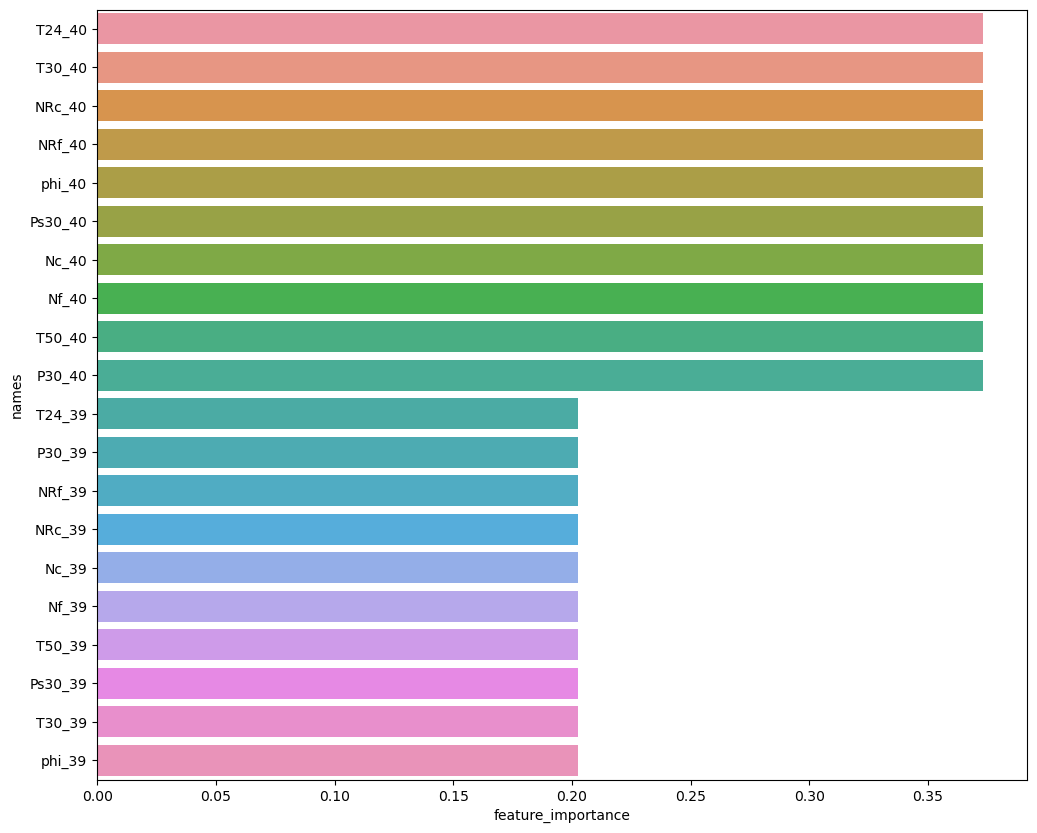

In [57]:
# import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 10))
sns.barplot(df_sorted, x='feature_importance', y = 'names')
plt.savefig('results/top20_shap.png')
plt.show()

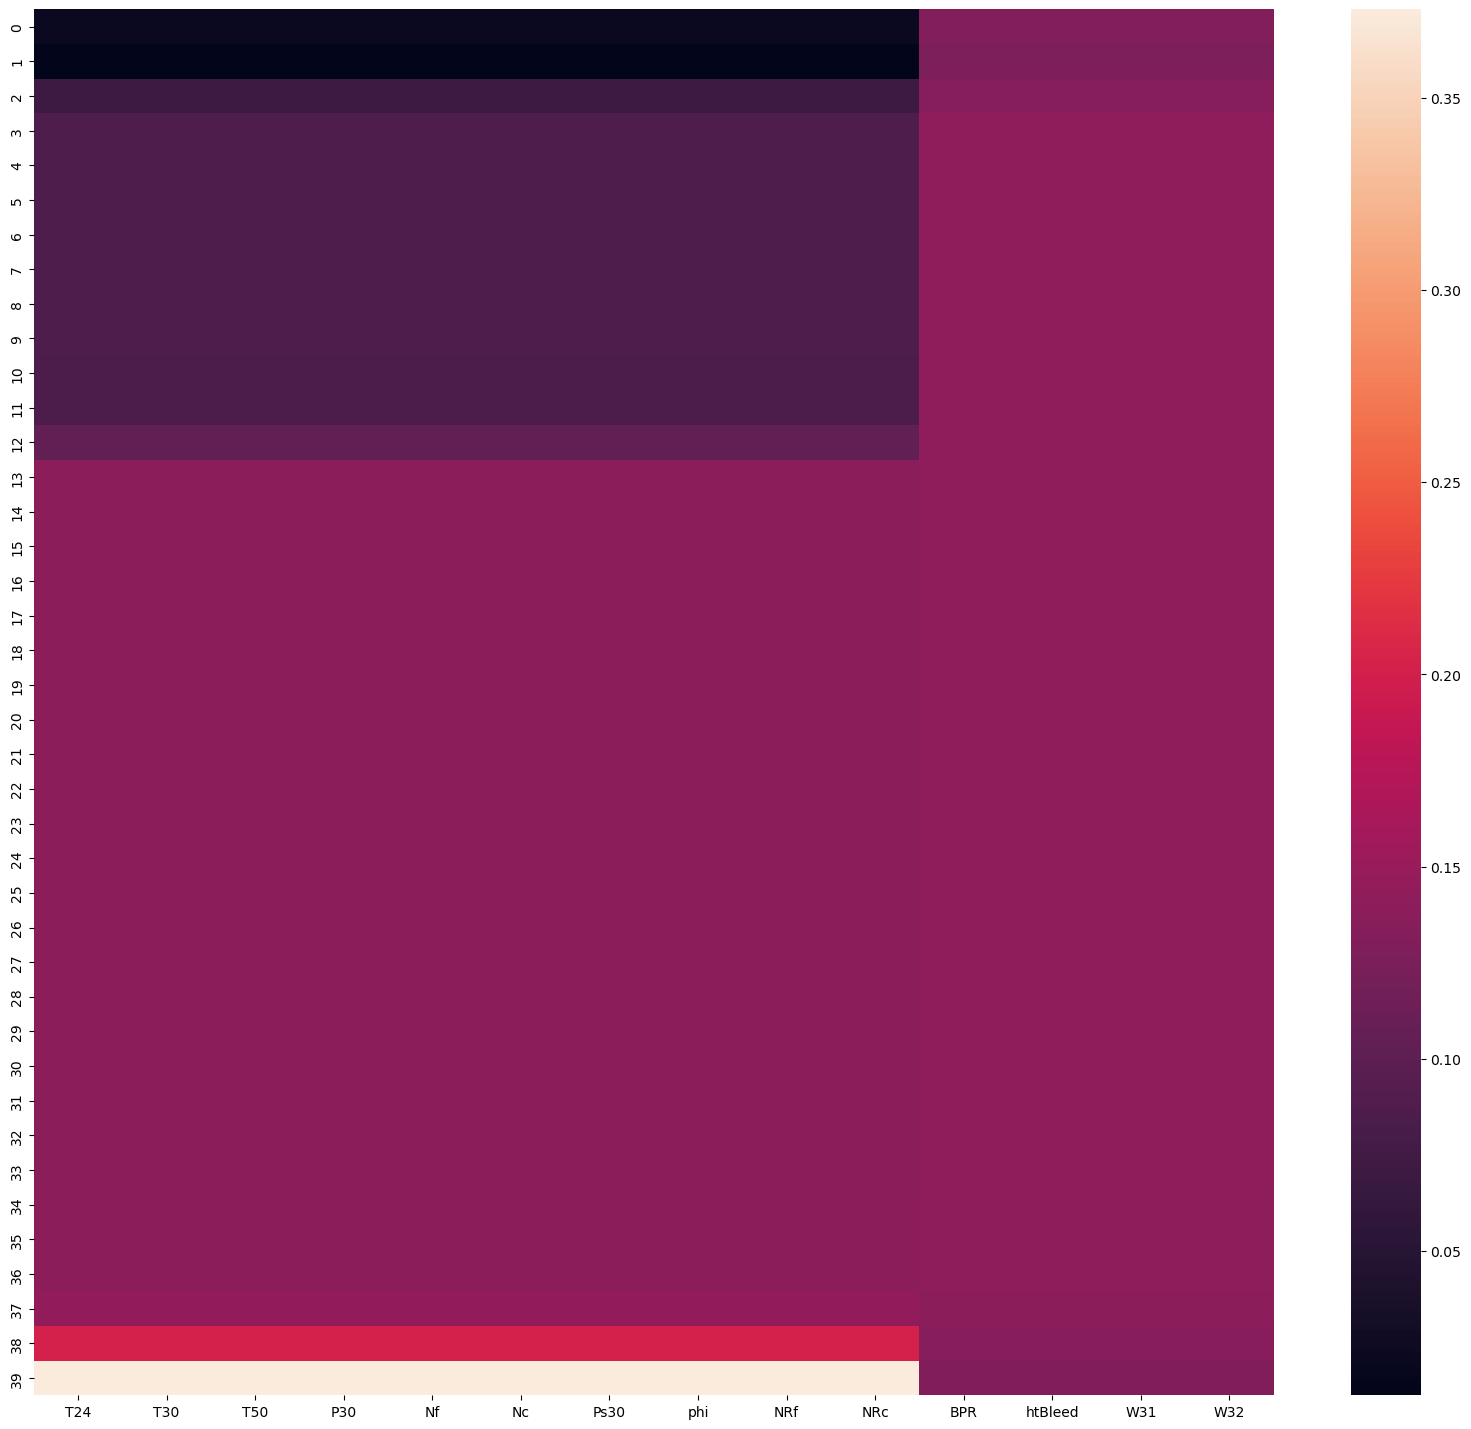

In [58]:
exp_reshap = abs(Shap_values).reshape(xi.shape)
exp_reshap.shape

df_test = pd.DataFrame(exp_reshap[0])
df_test.columns = remaining_sensors
plt.figure(figsize=(20, 18))
sns.heatmap(df_test)
plt.savefig('results/heatmap_shap.png')
plt.show()

In [59]:
shap_unique = np.sum(abs(df_test), axis = 0)

In [60]:
shap_unique = shap_unique.sort_values(ascending=False)

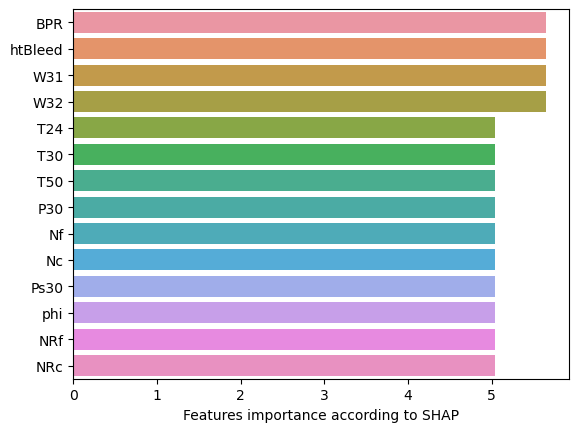

In [61]:
sns.barplot(x=shap_unique.values, y = shap_unique.index)
plt.xlabel('Features importance according to SHAP')
plt.savefig('results/top20_shap.png')
plt.show()

In [62]:
# Get lime feature importance
lime_explainer = RecurrentTabularExplainer(test_array, training_labels=label_array,
                                                       feature_names=remaining_sensors,
                                                       mode = 'regression',
                                                       )
lime_values = get_lime_explanation(xi, e = model.predict).values
explanations = {'Lime' : lime_values[0]}

157/157 [==============================] - 1s 5ms/step


In [63]:
# explainer_ = ['KernelSHAP', 'LIME', 'L2X']
idx = abs(explanations['Lime']).argsort()[-20:]

exp = explanations['Lime'][idx]
# var_names = np.array(var_names)[idx]
df_exp = pd.DataFrame({'idx' : idx, 'names' : np.array(var_names)[idx], 'feature_importance': abs(exp)})

In [64]:
df_exp['w_serted'] = abs(exp)
df_sorted = df_exp.sort_values('w_serted', ascending=False)

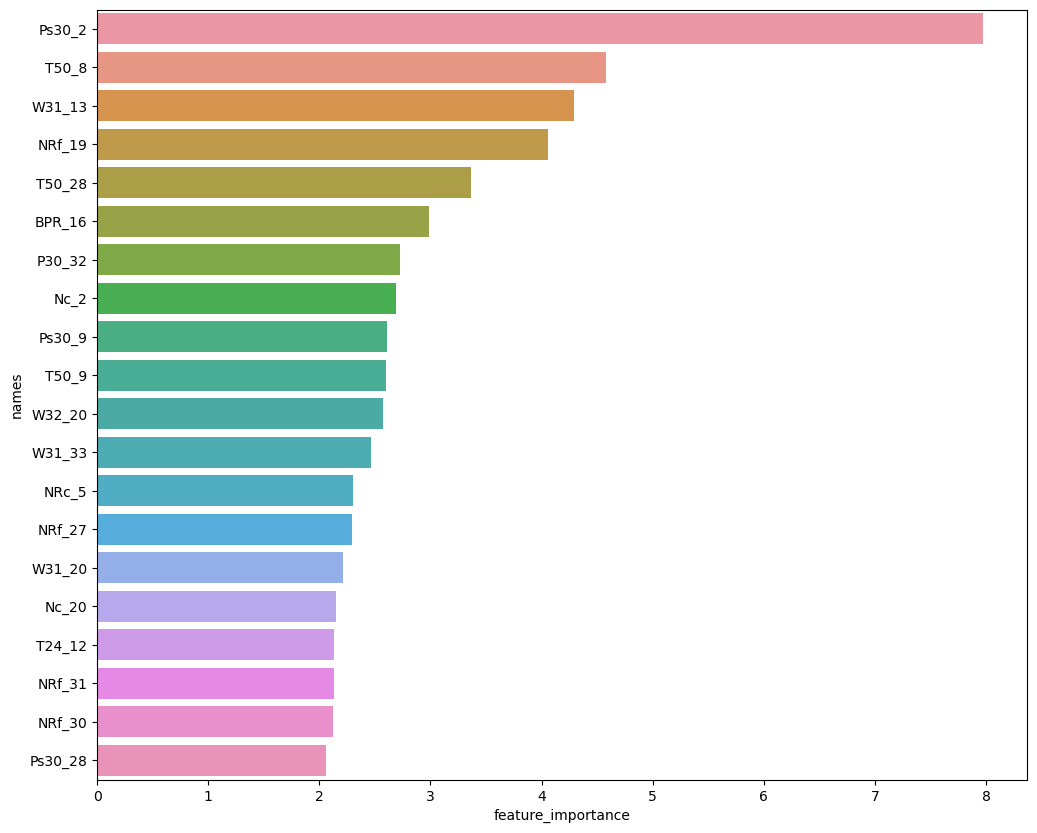

In [65]:
plt.figure(figsize=(12, 10))
sns.barplot(df_sorted, x='feature_importance', y = 'names')
plt.savefig('results/top20_lime.png')
plt.show()

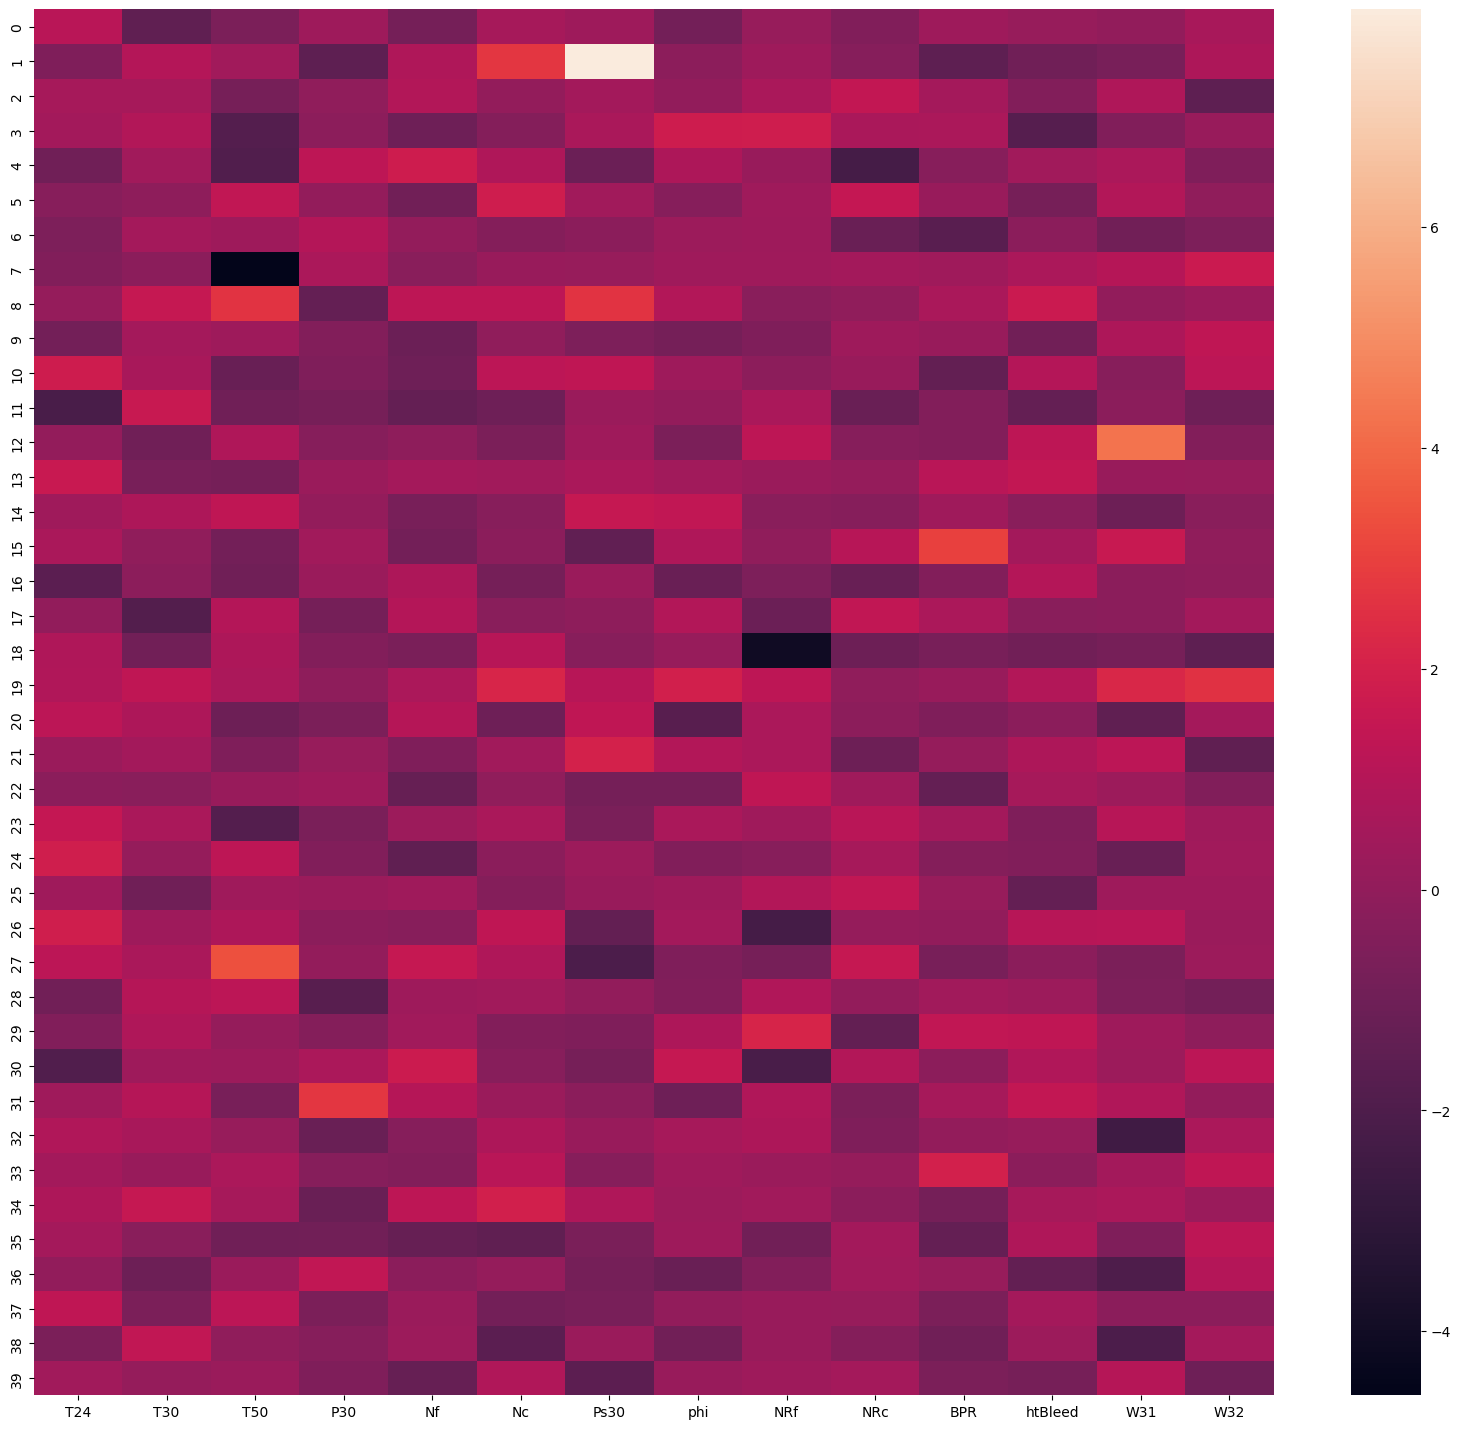

In [66]:
exp_reshap = lime_values.reshape(xi.shape)
exp_reshap.shape

df_test = pd.DataFrame(exp_reshap[0])
df_test.columns = remaining_sensors
plt.figure(figsize=(20, 18))
sns.heatmap(df_test)
plt.savefig('results/heatmap_lime.png')
plt.show()

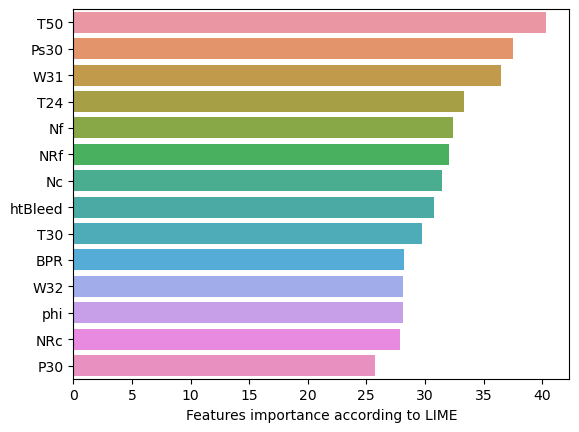

In [67]:
lime_unique = np.sum(abs(df_test), axis = 0)
lime_unique = lime_unique.sort_values(ascending=False)
sns.barplot(x=lime_unique.values, y = lime_unique.index)
plt.xlabel('Features importance according to LIME')
plt.savefig('results/top20_lime.png')
plt.show()

In [69]:
# L2X
xi  = test_array[20:21]
e = L2X(model.predict, xi)
Shap_values = get_explainations(xi, e, L2X = True).values

1/1 [==============================] - 1s 1s/step - loss: 6269.1782 - mse: 6268.4131 - val_loss: 6311.2607 - val_mse: 6310.5166


In [70]:
l2x_values = get_explainations(xi, e, L2X = True).values

In [71]:
# l2x_values = Shap_values
# explainer_ = ['KernelSHAP', 'LIME', 'L2X']
explanations = {'l2x' : l2x_values[0]}
idx = abs(explanations['l2x']).argsort()[-20:]

exp = explanations['l2x'][idx]
# var_names = np.array(var_names)[idx]
df_exp = pd.DataFrame({'idx' : idx, 'names' : np.array(var_names)[idx], 'feature_importance': exp})

In [72]:
df_exp['w_serted'] = abs(exp)
df_sorted = df_exp.sort_values('w_serted', ascending=False)

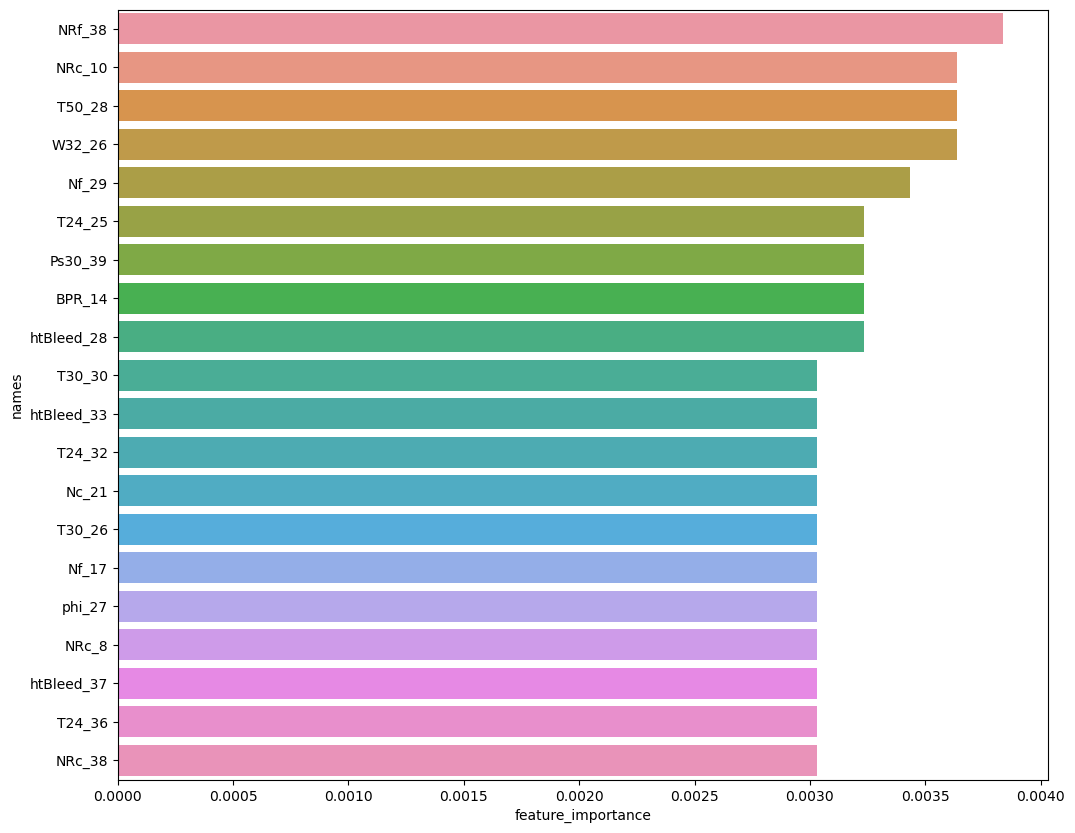

In [73]:
plt.figure(figsize=(12, 10))
sns.barplot(df_sorted, x='feature_importance', y = 'names')
plt.savefig('results/top20_l2x.png')
plt.show()

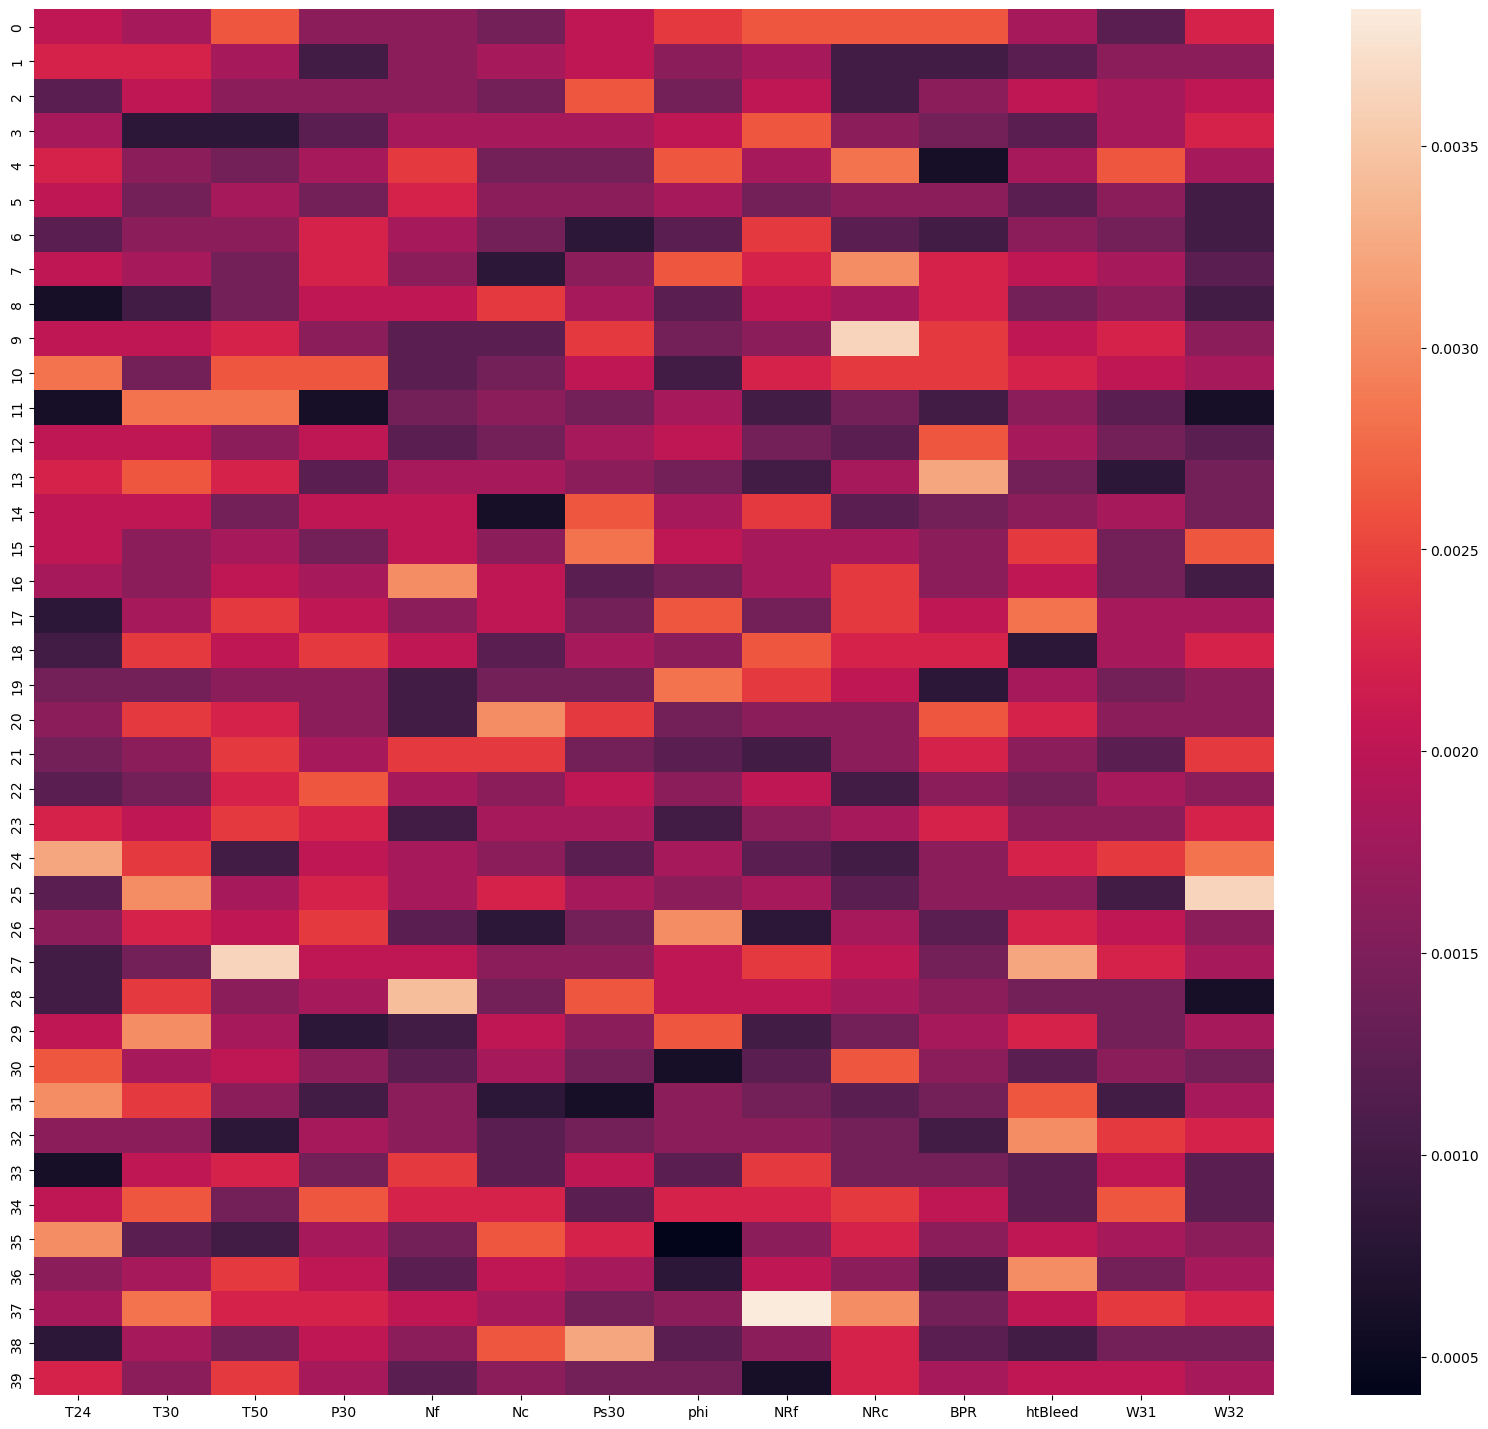

In [74]:
exp_reshap = l2x_values.reshape(xi.shape)
exp_reshap.shape

df_test = pd.DataFrame(exp_reshap[0])
df_test.columns = remaining_sensors
plt.figure(figsize=(20, 18))
sns.heatmap(df_test)
plt.savefig('results/heatmap_l2x.png')
plt.show()

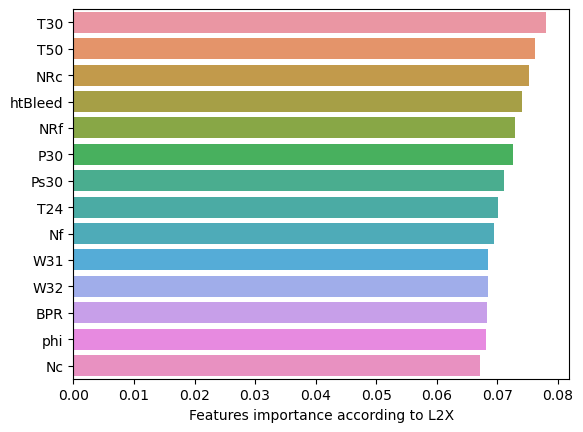

In [75]:
l2x_unique = np.sum(abs(df_test), axis = 0)
l2x_unique = l2x_unique.sort_values(ascending=False)
sns.barplot(x=l2x_unique.values, y = l2x_unique.index)
plt.xlabel('Features importance according to L2X')
plt.savefig('results/top20_l2x.png')
plt.show()

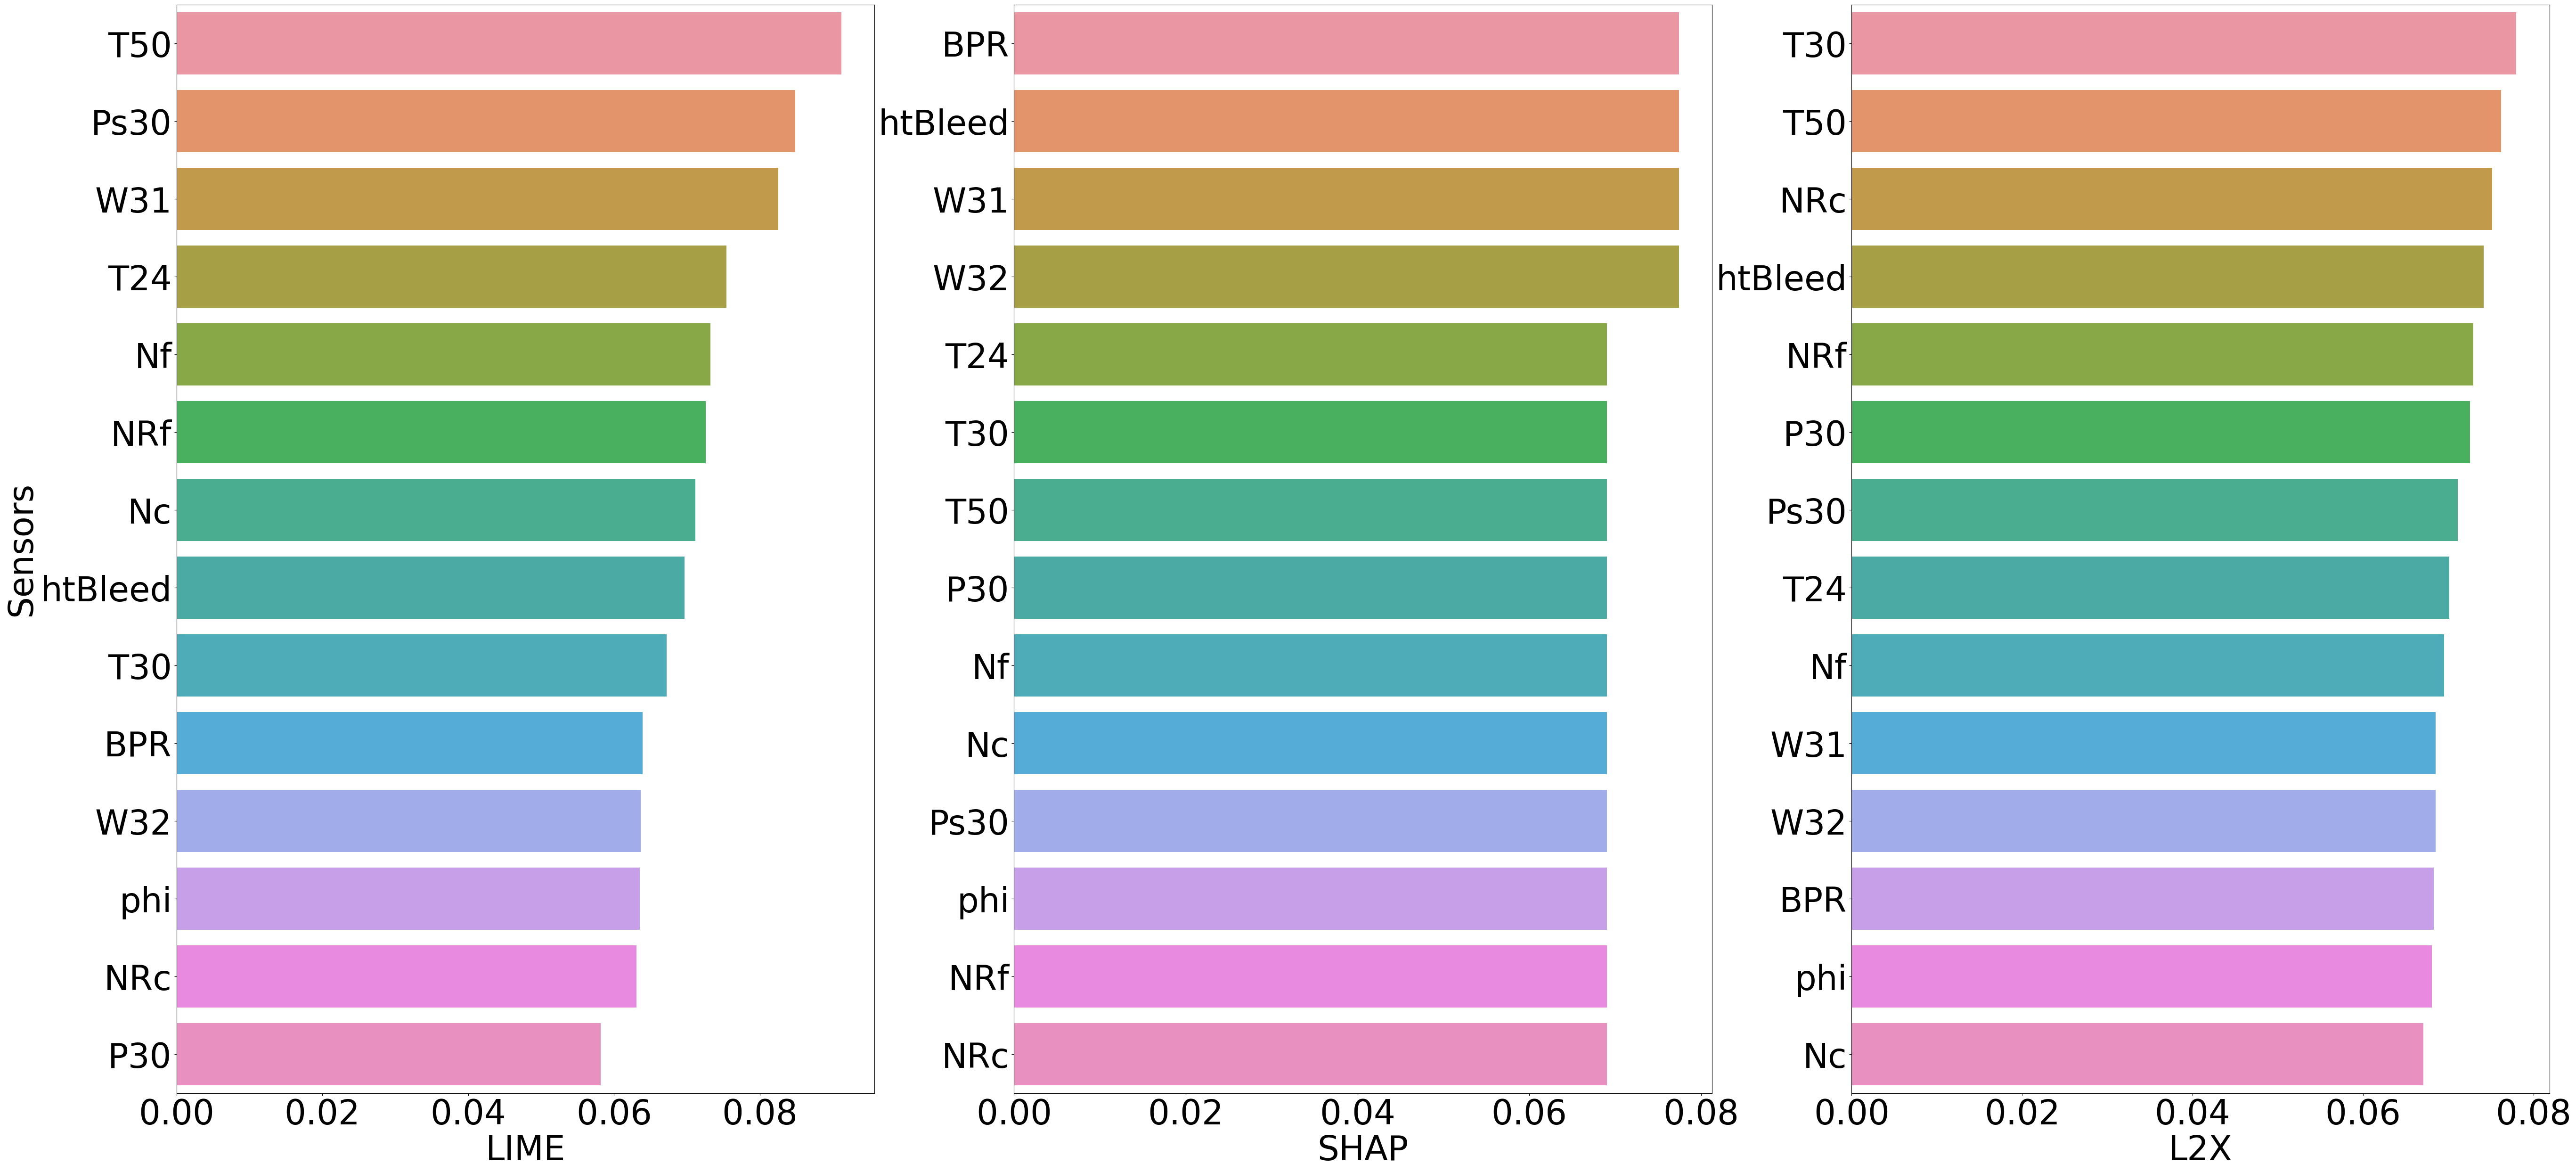

In [126]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 52})

plt.figure(figsize=(65,30))
plt.subplot(1,3,1)
sns.barplot(x=lime_unique.values/lime_unique.values.sum(), y = lime_unique.index)
plt.xlabel('LIME')
plt.ylabel('Sensors')

plt.subplot(1,3,2)
sns.barplot(x=shap_unique.values/shap_unique.values.sum(), y = shap_unique.index)
plt.xlabel('SHAP')

plt.subplot(1,3,3)
sns.barplot(x=l2x_unique.values, y = l2x_unique.index)
plt.xlabel('L2X')
plt.savefig('results/TOP20_feature.png')
plt.show()

In [24]:
from tqdm import tqdm
df_metrics = pd.DataFrame()

if True :
    # Get explanation and calculate the score
    # Echantillonage
    n_individus = test_array.shape[0]

    # # Choisir aléatoirement 10 indices d'individus
    np.random.seed(0)
    indices_choisis = np.random.choice(n_individus, size=10, replace=False)

    # Sélectionner les données correspondant aux indices choisis
    test_array_sampling = test_array[indices_choisis, :, :]
    label_array_sampling = y_test.values[indices_choisis, :]

    # Afficher les dimensions des données sélectionnées
    print(test_array_sampling.shape, label_array_sampling.shape)
    
    # distance matrix XX'
    X_dist = pd.DataFrame(squareform(pdist(test_array_sampling.reshape((test_array_sampling.shape[0], -1)))))

    # LIME
    lime_explainer = RecurrentTabularExplainer(test_array, training_labels=label_array,
                                                       feature_names=remaining_sensors,
                                                       mode = 'regression',
                                                       )
    lime_values = get_lime_explanation(test_array_sampling, e = model.predict)
    lime_values.shape
    Lime_dist = pd.DataFrame(squareform(pdist(lime_values))) # Lime values explanation matrix

    #Lime's metrics
    list_metrics_lime = {}
    list_metrics_lime['identity'] = identity(X_dist, Lime_dist)
    list_metrics_lime['separability'] = separability(X_dist, Lime_dist)
    list_metrics_lime['stability'] = stability(X_dist, Lime_dist)
    list_metrics_lime['coherence'], list_metrics_lime['completness'], list_metrics_lime['congruence'] = coherence(model=model.predict, 
                                                explainer = get_lime_explanation,
                                               samples=test_array_sampling,
                                                targets=label_array, e = model.predict)
    list_metrics_lime['selectivity'] = selectivity(model=model.predict, explainer = get_lime_explanation,
                                               samples=test_array_sampling, e_x = model.predict)
    list_metrics_lime['accumen'] = acumen(get_lime_explanation, test_array_sampling, e=model.predict)
    list_metrics_lime['alpha'] = alpha
    list_metrics_lime['upper'] = upper
    list_metrics_lime['sequence_length'] = sequence_length
    list_metrics_lime['explainer'] = 'lime'
    
    df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_lime])])
    
    # SHAP
    e = KernelSHAP(model)
    shapvalues = get_explainations(test_array_sampling, e)
    shapvalues.shape

    list_metrics_shap = {}
    shap_dist = pd.DataFrame(squareform(pdist(shapvalues))) # shap values explanation matrix
    
    list_metrics_shap['identity'] = identity(X_dist, shap_dist)
    list_metrics_shap['separability'] = separability(X_dist, shap_dist)
    list_metrics_shap['stability'] = stability(X_dist, shap_dist)
    list_metrics_shap['coherence'], list_metrics_shap['completness'], list_metrics_shap['congruence'] = coherence(model=model.predict, 
                                                explainer = get_explainations,
                                               samples=test_array_sampling,
                                                targets=label_array, e = e)
    list_metrics_shap['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
                                   samples=test_array_sampling, e_x=e)
    list_metrics_shap['accumen'] = acumen(get_explainations, test_array_sampling, e=e)
    
    list_metrics_shap['alpha'] = alpha
    list_metrics_shap['upper'] = upper
    list_metrics_shap['sequence_length'] = sequence_length
    list_metrics_shap['explainer'] = 'shap'

    df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_shap])])
    
    # Saliency
    e = Saliency(model)
    saliencyvalues = get_explainations(test_array_sampling, e)
    saliencyvalues.shape

    # #Saliency's metrics
    list_metrics_saliency = {}
    saliency_dist = pd.DataFrame(squareform(pdist(saliencyvalues))) # Lime values explanation matrix

    list_metrics_saliency['identity'] = identity(X_dist, saliency_dist)
    list_metrics_saliency['separability'] = separability(X_dist, saliency_dist)
    list_metrics_saliency['stability'] = stability(X_dist, saliency_dist)

    list_metrics_saliency['coherence'], list_metrics_saliency['completness'], list_metrics_saliency['congruence'] = coherence(model=model.predict, 
                                                explainer = get_explainations,
                                               samples=test_array_sampling,
                                                targets=label_array, e = e)
    list_metrics_saliency['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
                                   samples=test_array_sampling, e_x=e)
    list_metrics_saliency['accumen'] = 'NA'
    
    list_metrics_saliency['alpha'] = alpha
    list_metrics_saliency['upper'] = upper
    list_metrics_saliency['sequence_length'] = sequence_length
    list_metrics_saliency['explainer'] = 'saliency'
    df_metrics = pd.concat([df_metrics, pd.DataFrame([list_metrics_saliency])])
    
    # L2X
    e = L2X(model.predict, test_array_sampling)
    l2xvalues = get_explainations(test_array_sampling, e, L2X=True)
    l2xvalues.shape

    # Saliency's metrics
    list_metrics_l2x = {}
    l2x_dist = pd.DataFrame(squareform(pdist(l2xvalues))) # Lime values explanation matrix

    list_metrics_l2x['identity'] = identity(X_dist, l2x_dist)
    list_metrics_l2x['separability'] = separability(X_dist, l2x_dist)
    list_metrics_l2x['stability'] = stability(X_dist, l2x_dist)

    list_metrics_l2x['coherence'], list_metrics_l2x['completness'], list_metrics_l2x['congruence'] = coherence(model=model.predict, explainer = get_explainations,
                                               samples=test_array_sampling, targets=label_array_sampling, e = e, L2X=True)

    list_metrics_l2x['selectivity'] = selectivity(model=model.predict, explainer = get_explainations,
                                   samples=test_array_sampling, e_x=e, L2X=True)

    list_metrics_l2x['accumen'] = acumen(get_explainations, test_array_sampling, e=e, L2X=True)
    
    list_metrics_l2x['alpha'] = alpha
    list_metrics_l2x['upper'] = upper
    list_metrics_l2x['sequence_length'] = sequence_length
    list_metrics_l2x['explainer'] = 'l2x'

(10, 40, 14) (10, 1)
1/1 [==============================] - 0s 19ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

18/18 [==============================] - 0s 4ms/step



 10%|████████▎                                                                          | 1/10 [00:02<00:18,  2.03s/it]

18/18 [==============================] - 0s 4ms/step



 20%|████████████████▌                                                                  | 2/10 [00:03<00:15,  1.96s/it]

18/18 [==============================] - 0s 4ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:05<00:13,  1.93s/it]

18/18 [==============================] - 0s 5ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:07<00:11,  1.95s/it]

18/18 [==============================] - 0s 4ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:09<00:09,  1.96s/it]

18/18 [==============================] - 0s 5ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:11<00:07,  2.00s/it]

18/18 [==============================] - 0s 4ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:13<00:05,  1.98s/it]

18/18 [==============================] - 0s 4ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:15<00:03,  1.97s/it]

18/18 [==============================] - 0s 4ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:17<00:01,  1.98s/it]

18/18 [==============================] - 0s 5ms/step


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

157/157 [==============================] - 1s 5ms/step



 10%|████████▎                                                                          | 1/10 [00:03<00:33,  3.70s/it]

157/157 [==============================] - 1s 4ms/step



 20%|████████████████▌                                                                  | 2/10 [00:07<00:29,  3.70s/it]

157/157 [==============================] - 1s 4ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:11<00:26,  3.77s/it]

157/157 [==============================] - 1s 4ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:15<00:22,  3.80s/it]

157/157 [==============================] - 1s 4ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:18<00:18,  3.76s/it]

157/157 [==============================] - 1s 5ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:22<00:14,  3.74s/it]

157/157 [==============================] - 1s 4ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:26<00:11,  3.73s/it]

157/157 [==============================] - 1s 4ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:29<00:07,  3.67s/it]

157/157 [==============================] - 1s 4ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:33<00:03,  3.66s/it]

157/157 [==============================] - 1s 4ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.70s/it]

1/8 [==>...........................] - ETA: 0s

1/1 [==============================] - 0s 21ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

18/18 [==============================] - 0s 4ms/step



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.54it/s]

18/18 [==============================] - 0s 4ms/step



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.55it/s]

18/18 [==============================] - 0s 5ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.53it/s]

18/18 [==============================] - 0s 4ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.49it/s]

18/18 [==============================] - 0s 6ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.47it/s]

18/18 [==============================] - 0s 5ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.50it/s]

18/18 [==============================] - 0s 5ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:02,  1.47it/s]

18/18 [==============================] - 0s 4ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.48it/s]

18/18 [==============================] - 0s 5ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.46it/s]

18/18 [==============================] - 0s 4ms/step


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 0s 8ms/step



 10%|████████▎                                                                          | 1/10 [00:01<00:09,  1.05s/it]

8/8 [==============================] - 0s 7ms/step



 20%|████████████████▌                                                                  | 2/10 [00:02<00:08,  1.06s/it]

8/8 [==============================] - 0s 9ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:05<00:14,  2.01s/it]

8/8 [==============================] - 0s 10ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:09,  1.66s/it]

8/8 [==============================] - 0s 9ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:07<00:07,  1.50s/it]

8/8 [==============================] - 0s 11ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:08<00:05,  1.39s/it]

8/8 [==============================] - 0s 10ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:09<00:03,  1.31s/it]

8/8 [==============================] - 0s 11ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:11<00:02,  1.28s/it]

8/8 [==============================] - 0s 13ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:12<00:01,  1.24s/it]

8/8 [==============================] - 0s 11ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.35s/it]


1/1 [==============================] - 0s 18ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step



 10%|████████▎                                                                          | 1/10 [00:00<00:01,  5.83it/s]

2/2 [==============================] - 0s 0s/step



 20%|████████████████▌                                                                  | 2/10 [00:00<00:01,  5.37it/s]

2/2 [==============================] - 0s 0s/step



 30%|████████████████████████▉                                                          | 3/10 [00:00<00:01,  5.47it/s]

2/2 [==============================] - 0s 0s/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:00<00:01,  4.96it/s]

2/2 [==============================] - 0s 4ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:00<00:01,  4.98it/s]

2/2 [==============================] - 0s 5ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:01<00:00,  5.13it/s]

2/2 [==============================] - 0s 5ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:01<00:00,  5.32it/s]

2/2 [==============================] - 0s 8ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:01<00:00,  5.15it/s]

2/2 [==============================] - 0s 5ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:01<00:00,  5.27it/s]

2/2 [==============================] - 0s 5ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.23it/s]

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 23ms/step



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

18/18 [==============================] - 0s 7ms/step



 10%|████████▎                                                                          | 1/10 [00:10<01:35, 10.59s/it]

18/18 [==============================] - 0s 8ms/step



 20%|████████████████▌                                                                  | 2/10 [00:22<01:32, 11.53s/it]

18/18 [==============================] - 0s 6ms/step



 30%|████████████████████████▉                                                          | 3/10 [00:32<01:16, 10.87s/it]

18/18 [==============================] - 0s 8ms/step



 40%|█████████████████████████████████▏                                                 | 4/10 [00:43<01:03, 10.62s/it]

18/18 [==============================] - 0s 5ms/step



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:53<00:52, 10.50s/it]

18/18 [==============================] - 0s 7ms/step



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:03<00:41, 10.43s/it]

18/18 [==============================] - 0s 7ms/step



 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:15<00:32, 10.77s/it]

18/18 [==============================] - 0s 6ms/step



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:25<00:21, 10.77s/it]

18/18 [==============================] - 0s 8ms/step



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:36<00:10, 10.62s/it]

18/18 [==============================] - 0s 7ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:21<00:00, 20.18s/it]


In [25]:
df_metrics

,identity,separability,stability,coherence,completness,congruence,selectivity,accumen,alpha,upper,sequence_length,explainer
0,1.0,1.0,0.9,0.175953,0.052899,0.215055,0.688353,0.124973,0.5,100,40,lime
0,1.0,1.0,1.0,0.173228,0.360551,0.213728,0.605649,0.409481,0.5,100,40,shap
0,1.0,1.0,0.8,0.157234,0.412672,0.105833,0.538828,NA,0.5,100,40,saliency


In [21]:
df_metrics_1 = df_metrics
df_metrics_1

,identity,separability,stability,coherence,completness,congruence,selectivity,accumen,alpha,upper,sequence_length,explainer
0,1.0,1.0,0.9,0.175953,0.824045,0.215055,0.688353,0.124973,0.5,100,40,lime
0,1.0,1.0,1.0,0.173228,0.826012,0.213728,0.605649,0.409481,0.5,100,40,shap
0,1.0,1.0,0.8,0.157234,0.774165,0.105833,0.538828,NA,0.5,100,40,saliency


In [213]:
help(st)

Help on package stability_forlder:

NAME
    stability_forlder

DESCRIPTION
    This package implements the statistical tools for quantifying the stability of feature selection as given in [1].
    It includes 5 functions that provide:
        - the stability estimate of a feature selection procedure given its outputs;
        - the variance of the stability estimate;
        - a (1-alpha)- approximate confidence intervals for the population stability;
        - a null hypothesis test allowing to compare the population stability of a feature selection procedure to 
          a given value.
        - a null hypothesis test allowing to compare the population stabilities of two feature selection procedures.
    
    [1] On the Stability of Feature Selection. Sarah Nogueira, Konstantinos Sechidis, Gavin Brown. 
        Journal of Machine Learning Reasearch (JMLR). 2017.
    
    You can find a full demo using this package at:
    http://htmlpreview.github.io/?https://github.com/nogueirs/JM

In [1]:
import stability_forlder as st

In [2]:
## first we implement Z1 and Z2 as lists of size M*d
Z1=[[1,1,0],[1,1,0],[1,1,0]]
Z2=[[1,1,0],[0,1,1],[1,0,1]]
stab1=st.getStability(Z1)
stab2=st.getStability(Z2)
print('Stability of procedure 1 is :',stab1)
print('Stability of procedure 2 is :',stab2)

Stability of procedure 1 is : 1.0
Stability of procedure 2 is : -0.5
